<a href="https://colab.research.google.com/github/vnthoai/BigData-BI_L01_N19/blob/main/BigData%26BI_L01_N19%20(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.	Nạp dữ liệu (Ingestion): Chọn cách nạp: Batch ETL (full/incremental), micro/trickle ETL theo thời gian thực, hoặc truy cập trực tiếp nguồn. Luồng ETL nhiều lớp: Extract → Staging (chuẩn hoá chung) → Load vào kho dữ liệu; hỗ trợ Slowly Changing Dimensions, bulk load, và orchestration bằng công cụ điều phối (DAC).

2.	Lưu trữ & hạ tầng phân tán: Dùng distributed filesystem (HDFS, GFS, …): file được chia “chunk” 16–64MB, nhân bản 2–3 lần qua các rack; name node giữ metadata; triết lý “đưa tính toán tới dữ liệu”. Đây là nền cho MapReduce/Spark.

3.	Xử lý dòng (Streaming) — nếu dữ liệu đến liên tục: Mô hình xử lý dòng với bộ nhớ giới hạn, phục vụ standing queries (chạy thường trực) và ad-hoc (truy vấn tức thời). Kỹ thuật cốt lõi: lấy mẫu (simple/hierarchical; ví dụ hash theo user_id), đếm phần tử/đặc trưng (moments, distinct), lọc theo tiêu chí.

4.	Tiền xử lý dữ liệu (Data preprocessing):

•	Làm sạch: điền thiếu (mean/mode/ước lượng Bayes), phát hiện & xử lý outlier/noise (binning, clustering, regression), sửa không nhất quán, loại trùng.

•	Tích hợp nhiều nguồn/files.

•	Biến đổi: chuẩn hoá (normalization), tổng hợp (aggregation).

•	Giảm dữ liệu & rời rạc hoá (equi-width/equi-depth binning). Đây là bước then chốt trước khi OLAP/mining.

5.	Xử lý/Phân tích ở quy mô lớn:

•	MapReduce/Spark: lập trình Map → Group/Shuffle → Reduce cho tổng hợp/thống kê/truy vấn quan hệ phân tán.

•	Áp kỹ thuật khai phá dữ liệu/ML (recommendation, graph, NLP, time-series…) tuỳ use case.

6.	Lưu trữ phân tích & phục vụ kết quả: Đưa vào Data Warehouse/Data Mart → OLAP/BI: báo cáo, dashboard, chỉ số/KPI; quy trình Knowledge Discovery (từ dữ liệu thô → mẫu/quy tắc → tri thức) hỗ trợ ra quyết định.

7.	Vòng lặp vận hành: Tải lại theo lịch (Intervals/Time) để re-train/re-load incremental; giám sát, cảnh báo, và tối ưu hiệu năng nạp-chạy. (tham chiếu phần ETL scheduling/monitoring).

Áp vào dataset “Social Media Engagement”:

•	Phân loại cảm xúc/chủ đề: TF Hub BERT → Keras fine-tune. (XEM LẠI)

•	Dự báo tương tác: mô hình tabular (Wide&Deep/GBDT-stacking với Keras) dùng likes/shares/comments/impressions + đặc trưng text.

•	Gợi ý thời điểm đăng/hashtag: ranking (TF-Ranking) theo xác suất engagement.

•	Phát hiện bất thường: Autoencoder trên chuỗi engagement_rate theo user/campaign.

•	Phân tích tăng trưởng: LSTM/Transformer trên series theo ngày để dự báo buzz_change_rate. (XEM LẠI)



In [ ]:
# ==========================================
# BƯỚC 1: NẠP DỮ LIỆU (INGESTION) — KHÔNG CẦN PIP
# Extract → Staging (CSV chuẩn hoá) → Load (SQLite)
# Chế độ: batch_full | batch_incremental | micro_trickle | direct
# Hỗ trợ: SCD Type 2 (dim_user, dim_post) + Bulk load + Orchestrator (DAG)
# ==========================================

import os, sys, csv, json, math, sqlite3, time, io
from pathlib import Path
from collections import defaultdict, deque
from datetime import datetime, timezone

# ==== Cấu hình ====
DATA_SRC = "/content/Social Media Engagement Dataset.csv"   # chỉnh nếu cần
WORKDIR = Path("/content/workdir"); WORKDIR.mkdir(parents=True, exist_ok=True)
STAGING_DIR = WORKDIR / "staging"; STAGING_DIR.mkdir(parents=True, exist_ok=True)
STATE_DIR = WORKDIR / "state"; STATE_DIR.mkdir(parents=True, exist_ok=True)
WAREHOUSE_DB = WORKDIR / "warehouse.sqlite"

# Chế độ nạp: 'batch_full' | 'batch_incremental' | 'micro_trickle' | 'direct'
INGEST_MODE = "batch_full"   # <--- đổi ở đây

# Cỡ lô
BULK_CHUNK_SIZE = 10000
MICRO_BATCH_SIZE = 2000
MICRO_SLEEP_SEC = 0.2

# ==== Tiện ích chung ====
def _now_utc_stamp():
    return datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")

def _normalize_name(name: str) -> str:
    return name.strip().lower().replace(" ", "_")

def _parse_time(s: str):
    # Thử các định dạng thường gặp; trả về ISO 8601 UTC string hoặc None
    if s is None: return None
    s = s.strip()
    if not s: return None
    fmts = [
        "%Y-%m-%d %H:%M:%S%z","%Y-%m-%d %H:%M:%S","%Y-%m-%dT%H:%M:%S%z","%Y-%m-%dT%H:%M:%S",
        "%d/%m/%Y %H:%M:%S","%m/%d/%Y %H:%M:%S","%Y-%m-%d","%d/%m/%Y","%m/%d/%Y"
    ]
    for f in fmts:
        try:
            dt = datetime.strptime(s, f)
            if dt.tzinfo is None:
                dt = dt.replace(tzinfo=timezone.utc)
            return dt.astimezone(timezone.utc).isoformat()
        except: pass
    # Thử parse “free form”
    try:
        from email.utils import parsedate_to_datetime
        dt = parsedate_to_datetime(s)
        if dt.tzinfo is None:
            dt = dt.replace(tzinfo=timezone.utc)
        return dt.astimezone(timezone.utc).isoformat()
    except: return None

def _detect_time_col(header):
    cands = [c for c in header if any(k in c for k in ["time","date","created","timestamp","posted"])]
    return cands[0] if cands else None

def _to_float_or_none(x):
    if x is None: return None
    sx = str(x).strip()
    if sx == "": return None
    try:
        return float(sx.replace(",", ""))  # chấp nhận "1,234"
    except: return None

def _read_csv_rows(path):
    with open(path, "r", encoding="utf-8", newline="") as f:
        snif = csv.Sniffer()
        sample = f.read(4096)
        f.seek(0)
        dialect = snif.sniff(sample) if sample else csv.excel
        reader = csv.DictReader(f, dialect=dialect)
        # chuẩn hoá tên cột
        fieldnames = [_normalize_name(c) for c in reader.fieldnames]
        # remap
        rows = []
        for raw in reader:
            row = {}
            for k, v in raw.items():
                row[_normalize_name(k)] = v
            rows.append(row)
        return fieldnames, rows

def _write_staging_csv(rows, fieldnames, prefix):
    ts = _now_utc_stamp()
    fp = STAGING_DIR / f"{prefix}_{ts}.csv"
    with open(fp, "w", encoding="utf-8", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames, extrasaction="ignore")
        writer.writeheader()
        writer.writerows(rows)
    return fp

def _save_watermark(value: str | None):
    (STATE_DIR / "watermark.json").write_text(json.dumps({"watermark": value}))

def _load_watermark():
    p = STATE_DIR / "watermark.json"
    return json.loads(p.read_text())["watermark"] if p.exists() else None

# ==== Warehouse (SQLite) + SCD2 ====
def _conn():
    c = sqlite3.connect(WAREHOUSE_DB)
    c.execute("PRAGMA journal_mode=WAL;")
    c.execute("PRAGMA synchronous=OFF;")
    return c

def _ensure_tables(c):
    c.executescript("""
    CREATE TABLE IF NOT EXISTS dim_user (
        user_key INTEGER PRIMARY KEY,
        user_id TEXT,
        user_name TEXT,
        effective_from TEXT NOT NULL,
        effective_to TEXT,
        is_current INTEGER NOT NULL
    );
    CREATE INDEX IF NOT EXISTS idx_dim_user_id_current ON dim_user(user_id, is_current);

    CREATE TABLE IF NOT EXISTS dim_post (
        post_key INTEGER PRIMARY KEY,
        post_id TEXT,
        post_title TEXT,
        effective_from TEXT NOT NULL,
        effective_to TEXT,
        is_current INTEGER NOT NULL
    );
    CREATE INDEX IF NOT EXISTS idx_dim_post_id_current ON dim_post(post_id, is_current);

    CREATE TABLE IF NOT EXISTS fact_engagement (
        fact_id INTEGER PRIMARY KEY,
        post_key INTEGER,
        user_key INTEGER,
        event_time TEXT,
        engagement REAL,
        likes REAL,
        comments REAL,
        shares REAL,
        extras_json TEXT,
        FOREIGN KEY(post_key) REFERENCES dim_post(post_key),
        FOREIGN KEY(user_key) REFERENCES dim_user(user_key)
    );
    """)
    c.commit()

def _upsert_scd2(c, table, natural_key, attrs: dict):
    now = datetime.now(timezone.utc).isoformat()
    cur = c.cursor()
    row = cur.execute(f"SELECT rowid, * FROM {table} WHERE {natural_key}=? AND is_current=1", (attrs[natural_key],)).fetchone()
    colnames = [d[1] for d in cur.execute(f"PRAGMA table_info({table})")]
    compare_cols = [k for k in attrs.keys() if k != natural_key and k in colnames]
    def insert_new():
        cols = list(attrs.keys()) + ["effective_from","effective_to","is_current"]
        vals = [attrs[k] for k in attrs.keys()] + [now, None, 1]
        ph = ",".join(["?"]*len(vals))
        cur.execute(f"INSERT INTO {table} ({','.join(cols)}) VALUES ({ph})", vals)
    if row is None:
        insert_new()
    else:
        rowdict = dict(zip(colnames, row[1:1+len(colnames)]))
        changed = any(str(rowdict.get(cn)) != str(attrs.get(cn)) for cn in compare_cols)
        if changed:
            cur.execute(f"UPDATE {table} SET effective_to=?, is_current=0 WHERE {natural_key}=? AND is_current=1", (now, attrs[natural_key]))
            insert_new()
    c.commit()

def _bulk_insert(c, table, rows):
    if not rows: return
    cols = sorted({k for r in rows for k in r.keys()})
    ph = ",".join(["?"]*len(cols))
    data = [tuple(r.get(k) for k in cols) for r in rows]
    cur = c.cursor()
    cur.execute("BEGIN")
    cur.executemany(f"INSERT INTO {table} ({','.join(cols)}) VALUES ({ph})", data)
    c.commit()

# ==== Ingestion modes ====
def ingest_batch_full():
    header, rows = _read_csv_rows(DATA_SRC)
    time_col = _detect_time_col(header)
    # chuẩn hoá kiểu dữ liệu cơ bản
    for r in rows:
        if time_col:
            r[time_col] = _parse_time(r.get(time_col))
    fp = _write_staging_csv(rows, header, "full")
    return [fp], time_col, rows

def ingest_batch_incremental():
    header, rows = _read_csv_rows(DATA_SRC)
    time_col = _detect_time_col(header)
    if not time_col:
        print("⚠️ Không có cột thời gian — chuyển về full load.")
        return ingest_batch_full()
    wm = _load_watermark()
    if wm:
        rows = [r for r in rows if (_parse_time(r.get(time_col)) or "") > wm]
    # cập nhật watermark theo max của nguồn
    max_wm = None
    for r in _read_csv_rows(DATA_SRC)[1]:
        ts = _parse_time(r.get(time_col)) if time_col else None
        if ts and (max_wm is None or ts > max_wm):
            max_wm = ts
    if max_wm:
        _save_watermark(max_wm)
    # viết staging
    for r in rows:
        if time_col:
            r[time_col] = _parse_time(r.get(time_col))
    fp = _write_staging_csv(rows, header, "incr")
    return [fp], time_col, rows

def ingest_micro_trickle():
    header, rows = _read_csv_rows(DATA_SRC)
    time_col = _detect_time_col(header)
    paths = []
    for i in range(0, len(rows), MICRO_BATCH_SIZE):
        batch = rows[i:i+MICRO_BATCH_SIZE]
        for r in batch:
            if time_col:
                r[time_col] = _parse_time(r.get(time_col))
        fp = _write_staging_csv(batch, header, f"micro_{i//MICRO_BATCH_SIZE:04d}")
        paths.append(fp)
        time.sleep(MICRO_SLEEP_SEC)
    return paths, time_col, rows

def ingest_direct():
    # Vẫn ghi ra staging để đồng nhất bước load
    return ingest_batch_full()

# ==== Load staged → warehouse ====
def load_staged_to_warehouse(staging_paths, time_col_guess):
    c = _conn()
    _ensure_tables(c)

    # Đoán các cột id/metrics
    def metrics_names(cols):
        likes = next((x for x in cols if "like" in x), None)
        comments = next((x for x in cols if "comment" in x), None)
        shares = next((x for x in cols if "share" in x or "retweet" in x), None)
        return likes, comments, shares

    def ids_names(cols):
        user_id = next((x for x in cols if "user_id" in x), next((x for x in cols if ("user" in x and "id" in x)), None))
        post_id = next((x for x in cols if "post_id" in x), next((x for x in cols if ("post" in x and "id" in x)), None))
        return user_id, post_id

    # Tập hợp unique id để upsert SCD2 trước
    uniq_users, uniq_posts = set(), set()
    for p in staging_paths:
        with open(p, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            cols = [_normalize_name(c) for c in reader.fieldnames]
            ucol, pcol = ids_names(cols)
            if ucol or pcol:
                for r in reader:
                    if ucol and r.get(ucol): uniq_users.add(str(r[ucol]))
                    if pcol and r.get(pcol): uniq_posts.add(str(r[pcol]))

    for uid in uniq_users:
        _upsert_scd2(c, "dim_user", "user_id", {"user_id": uid, "user_name": None})
    for pid in uniq_posts:
        _upsert_scd2(c, "dim_post", "post_id", {"post_id": pid, "post_title": None})

    # Map id → surrogate key
    cur = c.cursor()
    user_map = {str(uid): uk for (uk, uid) in cur.execute("SELECT user_key, user_id FROM dim_user WHERE is_current=1").fetchall()}
    post_map = {str(pid): pk for (pk, pid) in cur.execute("SELECT post_key, post_id FROM dim_post WHERE is_current=1").fetchall()}

    # Build & bulk insert facts
    batch = []
    for p in staging_paths:
        with open(p, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            cols = [_normalize_name(c) for c in reader.fieldnames]
            likes_col, comments_col, shares_col = metrics_names(cols)
            ucol, pcol = ids_names(cols)
            for r in reader:
                # event_time
                event_time = None
                tc = time_col_guess or _detect_time_col(cols)
                if tc:
                    event_time = r.get(tc)
                    if event_time:
                        event_time = _parse_time(event_time)

                likes = _to_float_or_none(r.get(likes_col)) if likes_col else None
                comments = _to_float_or_none(r.get(comments_col)) if comments_col else None
                shares = _to_float_or_none(r.get(shares_col)) if shares_col else None

                # engagement = tổng 3 metric nếu có, ngược lại None
                metrics = [x for x in [likes, comments, shares] if x is not None]
                engagement = sum(metrics) if metrics else None

                batch.append({
                    "post_key": post_map.get(str(r.get(pcol))) if pcol else None,
                    "user_key": user_map.get(str(r.get(ucol))) if ucol else None,
                    "event_time": event_time,
                    "engagement": engagement,
                    "likes": likes,
                    "comments": comments,
                    "shares": shares,
                    "extras_json": None
                })
                if len(batch) >= BULK_CHUNK_SIZE:
                    _bulk_insert(c, "fact_engagement", batch); batch = []
    if batch:
        _bulk_insert(c, "fact_engagement", batch)

    c.close()
    print("Load → warehouse: OK")

# ==== Orchestrator (DAG) ====
class DAG:
    def __init__(self):
        self.edges = defaultdict(list)
        self.nodes = set()
    def add(self, u, v):
        self.edges[u].append(v); self.nodes.add(u); self.nodes.add(v)
    def topo(self):
        indeg = {n:0 for n in self.nodes}
        for u in self.nodes:
            for v in self.edges[u]:
                indeg[v]+=1
        q = deque([n for n in self.nodes if indeg[n]==0])
        order=[]
        while q:
            u=q.popleft(); order.append(u)
            for v in self.edges[u]:
                indeg[v]-=1
                if indeg[v]==0: q.append(v)
        return order

def run_orchestration(mode=INGEST_MODE):
    # B1 Extract → B2 Stage → B3 Load
    dag = DAG(); dag.add("extract","stage"); dag.add("stage","load")
    extract_output = None; time_col = None; raw_rows = None
    for step in dag.topo():
        print(f"=== Step: {step} ===")
        if step == "extract":
            if not Path(DATA_SRC).exists():
                try:
                    from google.colab import files
                    print("Không thấy file nguồn. Vui lòng upload CSV…")
                    uploaded = files.upload()
                    up_name = next(iter(uploaded.keys()))
                    if Path(DATA_SRC).name != up_name:
                        os.rename(up_name, Path(DATA_SRC).name)
                except Exception as e:
                    raise RuntimeError("Vui lòng upload file CSV trước.") from e
            if mode == "batch_full":
                extract_output, time_col, raw_rows = ingest_batch_full()
            elif mode == "batch_incremental":
                extract_output, time_col, raw_rows = ingest_batch_incremental()
            elif mode == "micro_trickle":
                extract_output, time_col, raw_rows = ingest_micro_trickle()
            elif mode == "direct":
                extract_output, time_col, raw_rows = ingest_direct()
            else:
                raise ValueError("Unknown INGEST_MODE")
            print(f"Extract xong. {len(extract_output)} file staging.")
        elif step == "stage":
            # Đã ghi file CSV staging trong bước extract
            print("Staging: OK (CSV trong thư mục staging)")
        elif step == "load":
            load_staged_to_warehouse(extract_output, time_col)
    print("DAG complete (Bước 1).")

# ==== CHẠY BƯỚC 1 ====
run_orchestration(INGEST_MODE)

# ==== Thống kê nhanh ====
if WAREHOUSE_DB.exists():
    con = sqlite3.connect(WAREHOUSE_DB); cur = con.cursor()
    def cnt(tbl):
        try: return cur.execute(f"SELECT COUNT(*) FROM {tbl}").fetchone()[0]
        except: return 0
    stats = {
        "dim_user": cnt("dim_user"),
        "dim_post": cnt("dim_post"),
        "fact_engagement": cnt("fact_engagement"),
    }
    con.close()
    print("Warehouse stats:", stats)


=== Step: extract ===
Không thấy file nguồn. Vui lòng upload CSV…


Saving Social Media Engagement Dataset.csv to Social Media Engagement Dataset.csv
Extract xong. 1 file staging.
=== Step: stage ===
Staging: OK (CSV trong thư mục staging)
=== Step: load ===
Load → warehouse: OK
DAG complete (Bước 1).
Warehouse stats: {'dim_user': 12000, 'dim_post': 12000, 'fact_engagement': 12000}


In [ ]:
# ==========================================
# BƯỚC 2: LƯU TRỮ & HẠ TẦNG PHÂN TÁN (HDFS-STYLE, TRONG COLAB)
# - DFS mô phỏng: chunk 32MB, replication 3, nhiều rack
# - NameNode giữ metadata (JSON)
# - Compute-near-data: map chạy tại rack có chunk
# - MapReduce tối giản
# - TensorFlow tf.data đọc nhiều shard song song (interleave)
# ==========================================

import os, json, csv, math, random, shutil, time
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Callable, Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed

# ----- Cấu hình chung -----
DATA_SRC = "/content/Social Media Engagement Dataset.csv"   # sửa nếu cần
DFS_ROOT = Path("/content/dfs")
NAMENODE = DFS_ROOT / "namenode" / "metadata.json"
RACKS = ["rackA", "rackB", "rackC"]                       # 3 rack mô phỏng
NODES_PER_RACK = 2                                        # mỗi rack có 2 datanode
REPLICATION = 3                                           # 2–3 theo HDFS; chọn 3 để demo
CHUNK_SIZE_MB = 32                                        # 16–64MB; dùng 32MB mặc định
CHUNK_SIZE_BYTES = CHUNK_SIZE_MB * 1024 * 1024

# TF config
BATCH_SIZE = 64
EPOCHS = 3

# ---------- Chuẩn bị môi trường ----------
# Nếu không thấy file nguồn, yêu cầu upload
if not Path(DATA_SRC).exists():
    try:
        from google.colab import files
        print("Không thấy file nguồn. Vui lòng upload CSV…")
        uploaded = files.upload()
        up_name = next(iter(uploaded.keys()))
        if up_name != Path(DATA_SRC).name:
            # đặt lại tên cho đồng nhất
            os.rename(up_name, Path(DATA_SRC).name)
        DATA_SRC = f"/content/{Path(DATA_SRC).name}"
    except Exception as e:
        raise RuntimeError("Vui lòng upload file CSV trước khi chạy.") from e

# Tạo cây thư mục DFS
def _init_dfs():
    if DFS_ROOT.exists():
        shutil.rmtree(DFS_ROOT)
    (DFS_ROOT / "namenode").mkdir(parents=True, exist_ok=True)
    for r in RACKS:
        for i in range(1, NODES_PER_RACK + 1):
            (DFS_ROOT / r / f"node{i}").mkdir(parents=True, exist_ok=True)

_init_dfs()

# ---------- Mô hình dữ liệu ----------
@dataclass
class ChunkInfo:
    chunk_id: str
    size: int
    replicas: List[str]  # danh sách "rack/node" nơi chứa bản sao (đường dẫn tương đối từ DFS_ROOT)

@dataclass
class FileInfo:
    filename: str
    chunks: List[ChunkInfo]

# ---------- NameNode ----------
class NameNode:
    def __init__(self, meta_path: Path):
        self.meta_path = meta_path
        self.fs: Dict[str, FileInfo] = {}   # map: logical file -> FileInfo
        if meta_path.exists():
            self.fs = self._load()
        else:
            self._persist()

    def _persist(self):
        obj = {k: {"filename": v.filename,
                   "chunks": [{"chunk_id": c.chunk_id, "size": c.size, "replicas": c.replicas}
                              for c in v.chunks]}
               for k, v in self.fs.items()}
        self.meta_path.parent.mkdir(parents=True, exist_ok=True)
        self.meta_path.write_text(json.dumps(obj, indent=2))

    def _load(self) -> Dict[str, FileInfo]:
        d = json.loads(self.meta_path.read_text()) if self.meta_path.exists() else {}
        out = {}
        for k, v in d.items():
            chunks = [ChunkInfo(**ci) for ci in v["chunks"]]
            out[k] = FileInfo(filename=v["filename"], chunks=chunks)
        return out

    def put(self, logical_name: str, fileinfo: FileInfo):
        self.fs[logical_name] = fileinfo
        self._persist()

    def get(self, logical_name: str) -> FileInfo:
        return self.fs[logical_name]

# ---------- DataNode helpers ----------
def _random_nodes_for_replication(replica_n=REPLICATION) -> List[str]:
    # chọn ngẫu nhiên rack/node khác nhau để mô phỏng phân tán & cross-rack
    candidates = []
    for r in RACKS:
        for i in range(1, NODES_PER_RACK + 1):
            candidates.append(f"{r}/node{i}")
    random.shuffle(candidates)
    return candidates[:replica_n]

def _write_replica(rel_node_path: str, chunk_id: str, data: bytes) -> Path:
    path = DFS_ROOT / rel_node_path / f"{chunk_id}.csv"
    path.write_bytes(data)
    return path

# ---------- Client: ghi file vào DFS (chunking + replication) ----------
def dfs_put(local_csv_path: str, logical_name: str) -> FileInfo:
    # Đọc source theo bytes, cắt chunk theo dòng để giữ header cho chunk đầu
    src = Path(local_csv_path)
    total = src.stat().st_size
    print(f"Ingest vào DFS: {src.name} ({total/1024/1024:.2f} MB), chunk ~{CHUNK_SIZE_MB}MB, replication={REPLICATION}")

    header_line = None
    chunks: List[ChunkInfo] = []
    with open(src, "rb") as f:
        # đọc header
        header_line = f.readline()
        buf = bytearray()
        buf.extend(header_line)
        chunk_idx = 0
        while True:
            line = f.readline()
            if not line:
                # flush cuối
                if len(buf) > len(header_line):
                    chunk_id = f"{src.stem}_part-{chunk_idx:05d}"
                    # replicate
                    targets = _random_nodes_for_replication()
                    for t in targets:
                        _write_replica(t, chunk_id, bytes(buf))
                    chunks.append(ChunkInfo(chunk_id=chunk_id, size=len(buf), replicas=targets))
                break
            # nếu vượt ngưỡng chunk, đóng chunk hiện tại
            if len(buf) + len(line) > CHUNK_SIZE_BYTES and len(buf) > len(header_line):
                chunk_id = f"{src.stem}_part-{chunk_idx:05d}"
                targets = _random_nodes_for_replication()
                for t in targets:
                    _write_replica(t, chunk_id, bytes(buf))
                chunks.append(ChunkInfo(chunk_id=chunk_id, size=len(buf), replicas=targets))
                chunk_idx += 1
                # reset buffer, ghi lại header cho chunk mới để CSV có header
                buf = bytearray()
                buf.extend(header_line)
            buf.extend(line)

    fi = FileInfo(filename=logical_name, chunks=chunks)
    return fi

# ---------- MapReduce nền tảng “đưa compute tới dữ liệu” ----------
# Map chạy tại node có chunk (đọc ngay file local của node)
def map_reduce(fileinfo: FileInfo,
               mapper: Callable[[Path], Dict],
               reducer: Callable[[List[Dict]], Dict],
               max_workers: int = 4) -> Dict:
    futures = []
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        for ch in fileinfo.chunks:
            # chọn 1 bản sao "gần" để chạy map
            node = random.choice(ch.replicas)
            shard_path = DFS_ROOT / node / f"{ch.chunk_id}.csv"
            futures.append(ex.submit(mapper, shard_path))
        maps = [f.result() for f in as_completed(futures)]
    return reducer(maps)

# ----- Ví dụ mapper/reducer: Tính tổng likes/comments/shares và số dòng -----
def mapper_sum_metrics(shard_path: Path) -> Dict[str, float]:
    likes = comments = shares = 0.0
    rows = 0
    with open(shard_path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        # tên cột đã normalize (do step 1 có thể chưa chạy, mình normalize nhẹ)
        norm = lambda s: s.strip().lower().replace(" ", "_")
        field_map = {norm(c): c for c in reader.fieldnames}
        lk = next((field_map[k] for k in field_map if "like" in k), None)
        cm = next((field_map[k] for k in field_map if "comment" in k), None)
        sh = next((field_map[k] for k in field_map if ("share" in k or "retweet" in k)), None)

        for r in reader:
            def to_f(x):
                if x is None or str(x).strip()=="":
                    return 0.0
                try:
                    return float(str(x).replace(",",""))
                except:
                    return 0.0
            likes += to_f(r.get(lk)) if lk else 0.0
            comments += to_f(r.get(cm)) if cm else 0.0
            shares += to_f(r.get(sh)) if sh else 0.0
            rows += 1
    return {"likes": likes, "comments": comments, "shares": shares, "rows": rows}

def reducer_sum(dicts: List[Dict]) -> Dict:
    out = {"likes":0.0,"comments":0.0,"shares":0.0,"rows":0}
    for d in dicts:
        for k in out:
            out[k] += d.get(k, 0.0)
    return out

# ---------- Thực thi: put + lưu metadata vào NameNode ----------
nn = NameNode(NAMENODE)
fi = dfs_put(DATA_SRC, logical_name=Path(DATA_SRC).name)
nn.put(fi.filename, fi)
print(f"NameNode ghi metadata: {NAMENODE}")

# ---------- Chạy MapReduce demo ----------
mr_res = map_reduce(fi, mapper_sum_metrics, reducer_sum, max_workers= min(8, len(fi.chunks) or 1))
print("Kết quả MapReduce (tổng hợp toàn file):", mr_res)

# ---------- TensorFlow: đọc dữ liệu phân mảnh (nhiều shard) ----------
import tensorflow as tf

# Tạo danh sách shard (đường dẫn bản sao đầu tiên của mỗi chunk để tránh đọc trùng)
shard_files = []
for ch in fi.chunks:
    # lấy 1 replica bất kỳ (hoặc chọn theo rack policy)
    node = ch.replicas[0]
    shard_files.append(str(DFS_ROOT / node / f"{ch.chunk_id}.csv"))

print(f"TF sẽ đọc {len(shard_files)} shard CSV (mỗi shard có header).")

# Tự động phát hiện cột cho TF
# Đọc một shard để suy ra schema đơn giản
sample_cols = []
if shard_files:
    with open(shard_files[0], "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        sample_cols = [c for c in reader.fieldnames]

def pick_cols(cols):
    norm = lambda s: s.strip().lower().replace(" ", "_")
    m = {norm(c): c for c in cols}
    # các cột số phổ biến
    like = m.get(next((k for k in m if "like" in k), ""), None)
    comm = m.get(next((k for k in m if "comment" in k), ""), None)
    share = m.get(next((k for k in m if ("share" in k or "retweet" in k)), ""), None)
    # fallback: nếu thiếu, bỏ qua
    feats = [c for c in [like, comm, share] if c]
    return feats

feature_cols = pick_cols(sample_cols)
target_col = None  # ta sẽ dùng y = likes + comments + shares (nếu có)

if not feature_cols:
    print("⚠️ Không phát hiện được cột likes/comments/shares. TF demo sẽ bỏ qua train.")
else:
    # make_csv_dataset sẽ tự đọc header; chọn đúng select_columns
    # Gộp các cột cần thiết; nếu thiếu cột nào -> loại bỏ
    select_cols = feature_cols

    ds = tf.data.experimental.make_csv_dataset(
        shard_files,
        batch_size=BATCH_SIZE,
        select_columns=select_cols,
        num_epochs=1,
        shuffle=True,
        num_parallel_reads=tf.data.AUTOTUNE,
        ignore_errors=True
    ).prefetch(tf.data.AUTOTUNE)

    # Xây y = tổng 3 feature (engagement) nếu đủ, ngược lại y = feature đầu tiên
    def map_xy(batch):
        # batch là dict tensor {col: tensor}
        xs = [tf.cast(batch[c], tf.float32) for c in feature_cols if c in batch]
        x = tf.stack(xs, axis=1) if len(xs) > 1 else xs[0][:, tf.newaxis]
        y = tf.reduce_sum(x, axis=1, keepdims=True) if len(xs) >= 2 else x
        return x, y

    ds_xy = ds.map(map_xy, num_parallel_calls=tf.data.AUTOTUNE).repeat(1)

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(feature_cols),)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    hist = model.fit(ds_xy, epochs=EPOCHS, verbose=1)
    # Đánh giá nhanh (đọc lại dataset)
    eval_res = model.evaluate(ds_xy, verbose=0)
    print("TF Eval (loss, mae):", eval_res)

# ---------- Giải thích nhanh ----------
print("""
✅ MÔ HÌNH HDFS (mô phỏng):
- File đầu vào được chia thành nhiều chunk ~{mb}MB.
- Mỗi chunk được replicate {rep} lần qua nhiều rack/node.
- NameNode (metadata.json) giữ mapping: logical file -> danh sách chunk + vị trí bản sao.
- MapReduce chạy 'gần dữ liệu': mỗi map đọc shard 'tại chỗ' (thư mục node chứa chunk).
- TensorFlow đọc nhiều shard CSV song song (interleave, num_parallel_reads), phù hợp triết lý 'đưa compute tới data'.
- Nền tảng này có thể nâng cấp sang Spark/MapReduce thật khi có cụm HDFS/GFS.
""".format(mb=CHUNK_SIZE_MB, rep=REPLICATION))

Ingest vào DFS: Social Media Engagement Dataset.csv (4.92 MB), chunk ~32MB, replication=3
NameNode ghi metadata: /content/dfs/namenode/metadata.json
Kết quả MapReduce (tổng hợp toàn file): {'likes': 29888643.0, 'comments': 6052149.0, 'shares': 12086006.0, 'rows': 12000}


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


TF sẽ đọc 1 shard CSV (mỗi shard có header).
Epoch 1/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8011656.0000 - mae: 2190.7061
Epoch 2/3
 22/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4405.7559 - mae: 51.6064   

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3251.3833 - mae: 42.4646
Epoch 3/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 804.4299 - mae: 18.0804
TF Eval (loss, mae): [386.2718811035156, 12.69266414642334]

✅ MÔ HÌNH HDFS (mô phỏng):
- File đầu vào được chia thành nhiều chunk ~32MB.
- Mỗi chunk được replicate 3 lần qua nhiều rack/node.
- NameNode (metadata.json) giữ mapping: logical file -> danh sách chunk + vị trí bản sao.
- MapReduce chạy 'gần dữ liệu': mỗi map đọc shard 'tại chỗ' (thư mục node chứa chunk).
- TensorFlow đọc nhiều shard CSV song song (interleave, num_parallel_reads), phù hợp triết lý 'đưa compute tới data'.
- Nền tảng này có thể nâng cấp sang Spark/MapReduce thật khi có cụm HDFS/GFS.



In [ ]:
# ==========================================
# BƯỚC 3 (ĐÃ SỬA): STREAMING + TF ONLINE
# - Tự phát hiện cột user; fallback nếu không có
# - Sampling ~10% (có thể chỉnh), luôn có dữ liệu vào reservoir
# - Tùy chọn tắt lọc để tránh loại hết bản ghi
# - KMV distinct + Count-Min Sketch + Moments
# - TF online theo micro-batch (nếu TF sẵn)
# ==========================================

import os, csv, time, math, random, hashlib, json
from pathlib import Path
from collections import defaultdict, deque
from dataclasses import dataclass
from typing import Callable, Dict, List, Optional, Iterable, Any

# ====== CẤU HÌNH ======
DATA_SRC = "/content/Social Media Engagement Dataset.csv"  # đổi nếu cần
MICRO_BATCH_SIZE = 1024
SLEEP_SEC = 0.02

# Điều chỉnh sampling
SAMPLE_RATE_PCT = 10       # ~10% theo hash; set 100 để nhận hết
FORCE_ACCEPT_IF_NO_UID = True  # nếu không tìm thấy cột user, nhận toàn bộ vào reservoir

# Lọc (predicate) — set False để không lọc gì cả
FILTER_ZERO_ENGAGEMENT = False

# TF online
TF_REPLAY_MAX = 10000
TF_EPOCHS_PER_BATCH = 1

# ====== TIỆN ÍCH ======
def _norm(s: str) -> str:
    return s.strip().lower().replace(" ", "_")

def _to_float(x):
    if x is None: return 0.0
    sx = str(x).strip()
    if not sx: return 0.0
    try:
        return float(sx.replace(",", ""))
    except:
        return 0.0

def _hash_u64(s: str) -> int:
    h = hashlib.blake2b(s.encode("utf-8"), digest_size=8).digest()
    return int.from_bytes(h, "big", signed=False)

# ====== ONLINE STATS ======
class Welford:
    def __init__(self):
        self.n=0; self.mean=0.0; self.M2=0.0
    def update(self, x: float):
        self.n+=1; d=x-self.mean; self.mean+=d/self.n; self.M2+=d*(x-self.mean)
    def var(self): return self.M2/(self.n-1) if self.n>1 else 0.0
    def std(self): return math.sqrt(self.var())

class CountMinSketch:
    def __init__(self, width=2048, depth=5, seed=1337):
        self.w=width; self.d=depth
        random.seed(seed)
        self.salts=[str(random.randint(0,10**9)) for _ in range(depth)]
        self.table=[[0]*width for _ in range(depth)]
    def _idx(self, key, i):
        h=hashlib.blake2b((self.salts[i]+"|"+key).encode(), digest_size=8).digest()
        return int.from_bytes(h,"big")%self.w
    def add(self,key,cnt=1):
        for i in range(self.d): self.table[i][self._idx(key,i)]+=cnt
    def estimate(self,key): return min(self.table[i][self._idx(key,i)] for i in range(self.d))

class KMVDistinct:
    def __init__(self,k=1024):
        self.k=k; self.heap=[]; self.maxv=None
    def offer(self,key:str):
        import heapq
        v=_hash_u64(key)/(1<<64)
        if len(self.heap)<self.k:
            heapq.heappush(self.heap,-v); self.maxv=-self.heap[0]
        else:
            if v<self.maxv:
                heapq.heapreplace(self.heap,-v); self.maxv=-self.heap[0]
    def estimate(self):
        if len(self.heap)<self.k: return len(self.heap)
        return (self.k-1)/self.maxv if self.maxv and self.maxv>0 else 0

class ReservoirSampler:
    def __init__(self,k=5000): self.k=k; self.buf=[]; self.n=0
    def offer(self,item):
        import random
        self.n+=1
        if len(self.buf)<self.k: self.buf.append(item)
        else:
            j=random.randint(1,self.n)
            if j<=self.k: self.buf[j-1]=item
    def sample(self): return list(self.buf)

# ====== HASH SAMPLER (THEO USER) ======
class HashSamplerByKey:
    def __init__(self, key_extractor: Callable[[dict], str], rate_pct:int=10):
        self.key_extractor=key_extractor
        self.mod=max(1, int(100/rate_pct))  # ví dụ 10% -> mod=10
    def accept(self,item:dict)->bool:
        key=self.key_extractor(item)
        if not key: return False
        return _hash_u64(str(key))%self.mod==0

# ====== ENGINE ======
class StreamingEngine:
    USER_ID_CANDIDATES = [
        "user_id","userid","author_id","username","user","creator_id","channel_id","account_id"
    ]
    def __init__(self, src_path: str, batch_size: int = MICRO_BATCH_SIZE, sleep_sec: float = SLEEP_SEC):
        self.src_path=src_path; self.batch_size=batch_size; self.sleep_sec=sleep_sec
        self.standing=[]
        self.moments={k:Welford() for k in ["likes","comments","shares","engagement"]}
        self.cms_users=CountMinSketch(); self.kmv_users=KMVDistinct()
        self.reservoir=ReservoirSampler(k=5000)
        self.records_seen=0
        self.user_col=None
        self.hash_sampler=None
        # TF
        self.tf_ready=False; self.tf_model=None
        self.tf_buffer_x=deque(maxlen=TF_REPLAY_MAX)
        self.tf_buffer_y=deque(maxlen=TF_REPLAY_MAX)

    # --- setup header & user column ---
    def _prepare_header(self):
        with open(self.src_path,"r",encoding="utf-8") as f:
            r=csv.DictReader(f)
            raw_cols=list(r.fieldnames)
        cols=[_norm(c) for c in raw_cols]
        # phát hiện user col
        for cand in self.USER_ID_CANDIDATES:
            if cand in cols: self.user_col=cand; break
        # Nếu không tìm thấy, tạo cột tổng hợp để sampling/đếm vẫn chạy
        if not self.user_col:
            self.user_col=None
        # tạo hash sampler
        if self.user_col:
            self.hash_sampler=HashSamplerByKey(lambda rec: rec.get(self.user_col,""), rate_pct=SAMPLE_RATE_PCT)
        else:
            # không có user: cho phép nhận vào reservoir theo FORCE_ACCEPT_IF_NO_UID
            self.hash_sampler=None
        print(f"[Detect] Columns: {cols}")
        print(f"[Detect] user_id column: {self.user_col or '(none)'}; sample rate ≈ {SAMPLE_RATE_PCT}%")

    # --- reader ---
    def _iter_records(self)->Iterable[dict]:
        with open(self.src_path,"r",encoding="utf-8") as f:
            reader=csv.DictReader(f)
            for raw in reader:
                r={_norm(k):v for k,v in raw.items()}
                likes=_to_float(r.get("likes")); comments=_to_float(r.get("comments")); shares=_to_float(r.get("shares"))
                r["likes"]=likes; r["comments"]=comments; r["shares"]=shares; r["engagement"]=likes+comments+shares
                yield r

    def _ensure_tf(self):
        if self.tf_ready: return
        try:
            import tensorflow as tf
            self.tf=tf
            self.tf_model=tf.keras.Sequential([
                tf.keras.layers.Input(shape=(3,)),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(1)
            ])
            self.tf_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            self.tf_ready=True
            print("TF ready:", tf.__version__)
        except Exception as e:
            print("⚠️ TensorFlow không khả dụng (sẽ bỏ qua train).")
            self.tf_ready=False

    def _train_tf(self):
        if not self.tf_ready: self._ensure_tf()
        if not self.tf_ready or len(self.tf_buffer_x)<64: return
        import numpy as np
        X=np.array(self.tf_buffer_x, dtype="float32")
        y=np.array(self.tf_buffer_y, dtype="float32")
        ds=self.tf.data.Dataset.from_tensor_slices((X,y)).batch(128).prefetch(self.tf.data.AUTOTUNE)
        self.tf_model.fit(ds, epochs=TF_EPOCHS_PER_BATCH, verbose=0)

    def run(self, max_batches: Optional[int]=10, apply_filter: bool = FILTER_ZERO_ENGAGEMENT):
        if not Path(self.src_path).exists():
            from google.colab import files
            print("Không thấy file nguồn. Vui lòng upload CSV…")
            uploaded=files.upload()
            up=next(iter(uploaded.keys()))
            if up!=Path(self.src_path).name: os.rename(up, Path(self.src_path).name)
        self._prepare_header()

        batch=[]
        for rec in self._iter_records():
            # ad-hoc filter
            if apply_filter and (rec["engagement"]<=0.0):
                pass  # bỏ qua
            else:
                # update stats
                for k in ["likes","comments","shares","engagement"]:
                    self.moments[k].update(rec[k])

                # user id update (nếu có)
                uid = rec.get(self.user_col,"") if self.user_col else (str(_hash_u64(json.dumps(rec))%10**12) if FORCE_ACCEPT_IF_NO_UID else "")
                if uid:
                    self.cms_users.add(str(uid),1)
                    self.kmv_users.offer(str(uid))

                # sampling
                accept = True
                if self.hash_sampler is not None:
                    accept = self.hash_sampler.accept(rec)
                elif not FORCE_ACCEPT_IF_NO_UID:
                    accept = False
                if accept:
                    self.reservoir.offer(rec)

                # TF buffer
                self.tf_buffer_x.append([rec["likes"],rec["comments"],rec["shares"]])
                self.tf_buffer_y.append([rec["engagement"]])

                batch.append(rec)
                self.records_seen+=1

                if len(batch)>=MICRO_BATCH_SIZE:
                    # train
                    self._train_tf()
                    # log
                    self._log_snapshot()
                    batch=[]
                    time.sleep(SLEEP_SEC)
                    if max_batches is not None and (self.records_seen//MICRO_BATCH_SIZE)>=max_batches:
                        break

        if batch:
            self._train_tf()
            self._log_snapshot()

    def _log_snapshot(self):
        est_users=int(self.kmv_users.estimate())
        print("[SNAPSHOT]", json.dumps({
            "records_seen": self.records_seen,
            "reservoir_size": len(self.reservoir.sample()),
            "approx_distinct_users_KMV": est_users,
            "eng_mean": round(self.moments["engagement"].mean,4),
            "likes_mean": round(self.moments["likes"].mean,4),
            "comments_mean": round(self.moments["comments"].mean,4),
            "shares_mean": round(self.moments["shares"].mean,4)
        }, ensure_ascii=False))

# ====== CHẠY THỬ ======
print("🚀 Bắt đầu stream (bước 3, đã sửa)…")
engine = StreamingEngine(DATA_SRC, batch_size=MICRO_BATCH_SIZE, sleep_sec=SLEEP_SEC)
engine.run(max_batches=10, apply_filter=FILTER_ZERO_ENGAGEMENT)

# AD-HOC sau khi chạy
print("\n=== AD-HOC ===")
print("Số mẫu trong reservoir:", len(engine.reservoir.sample()))
print("Ước lượng DISTINCT (KMV):", int(engine.kmv_users.estimate()))


🚀 Bắt đầu stream (bước 3, đã sửa)…
[Detect] Columns: ['post_id', 'timestamp', 'day_of_week', 'platform', 'user_id', 'location', 'language', 'text_content', 'hashtags', 'mentions', 'keywords', 'topic_category', 'sentiment_score', 'sentiment_label', 'emotion_type', 'toxicity_score', 'likes_count', 'shares_count', 'comments_count', 'impressions', 'engagement_rate', 'brand_name', 'product_name', 'campaign_name', 'campaign_phase', 'user_past_sentiment_avg', 'user_engagement_growth', 'buzz_change_rate']
[Detect] user_id column: user_id; sample rate ≈ 10%
TF ready: 2.19.0
[SNAPSHOT] {"records_seen": 1024, "reservoir_size": 100, "approx_distinct_users_KMV": 1024, "eng_mean": 0.0, "likes_mean": 0.0, "comments_mean": 0.0, "shares_mean": 0.0}
[SNAPSHOT] {"records_seen": 2048, "reservoir_size": 206, "approx_distinct_users_KMV": 2070, "eng_mean": 0.0, "likes_mean": 0.0, "comments_mean": 0.0, "shares_mean": 0.0}
[SNAPSHOT] {"records_seen": 3072, "reservoir_size": 312, "approx_distinct_users_KMV": 31

In [ ]:
# ==========================================
# BƯỚC 4: DATA PREPROCESSING + TF PIPELINE (COLAB) — BẢN ĐÃ CHỈNH
# Hỗ trợ hai kiểu tên cột:
#   - likes, shares, comments
#   - likes_count, shares_count, comments_count
# Tự tạo cột: engagement = likes(+_count) + shares(+_count) + comments(+_count)
# ==========================================

import os, csv, json, math, time, random, hashlib
from pathlib import Path
from datetime import datetime
from collections import Counter, defaultdict

import numpy as np
import pandas as pd

# ===== CẤU HÌNH =====
SOURCES = ["/content/Social Media Engagement Dataset.csv"]   # thêm đường dẫn nếu có nhiều file
WORKDIR = Path("/content/workdir"); WORKDIR.mkdir(parents=True, exist_ok=True)
OUT_CSV = WORKDIR / "processed.csv"
OUT_TFRECORD = WORKDIR / "processed.tfrecord"

IMPUTE_NUMERIC = "mean"       # "mean" | "median"
IMPUTE_CATEG  = "mode"        # "mode"
BAYES_SMOOTH  = True
BAYES_PRIOR_ALPHA = 1.0
BAYES_PRIOR_BETA  = 1.0

OUTLIER_METHOD = "iqr"        # "iqr" | "zscore" | "mad" | None
OUTLIER_CLIP_Q = (0.5, 99.5)

NORMALIZE = "zscore"          # "zscore" | "minmax" | None
AGGREGATE_BY = None           # None | "post_id" | "user_id" | "day"

BINNING = {"engagement": ("equi-depth", 10)}  # rời rạc hoá

# TF: sẽ tự cập nhật theo cột tìm thấy
TF_FEATURES = None            # tự đặt thành [likes*_col, comments*_col, shares*_col]
TF_TARGET   = "engagement"
TF_BATCH    = 64
TF_EPOCHS   = 3

# ===== TIỆN ÍCH =====
def norm_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

def try_parse_time(s):
    if pd.isna(s): return pd.NaT
    s = str(s).strip()
    if not s: return pd.NaT
    fmts = ["%Y-%m-%d %H:%M:%S%z","%Y-%m-%d %H:%M:%S","%Y-%m-%dT%H:%M:%S%z","%Y-%m-%dT%H:%M:%S",
            "%d/%m/%Y %H:%M:%S","%m/%d/%Y %H:%M:%S","%Y-%m-%d","%d/%m/%Y","%m/%d/%Y"]
    for f in fmts:
        try:
            return pd.to_datetime(datetime.strptime(s, f))
        except: pass
    try:
        return pd.to_datetime(s, errors="coerce")
    except:
        return pd.NaT

def union_concat(dfs: list[pd.DataFrame]) -> pd.DataFrame:
    all_cols = sorted({c for df in dfs for c in df.columns})
    dfs2 = [df.reindex(columns=all_cols) for df in dfs]
    return pd.concat(dfs2, ignore_index=True)

def mode_series(s: pd.Series):
    if s.dropna().empty: return np.nan
    return s.mode(dropna=True).iloc[0]

def bayes_smooth(success, total, a=1.0, b=1.0):
    success = success.fillna(0)
    total = total.fillna(0)
    return (success + a) / (total + a + b)

def detect_num_cat(df):
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in df.columns if c not in num_cols]
    return num_cols, cat_cols

def clip_outliers(df, cols, method="iqr"):
    df = df.copy()
    for c in cols:
        s = pd.to_numeric(df[c], errors="coerce")
        if method == "iqr":
            q1, q3 = np.nanpercentile(s, [25, 75]); iqr = q3 - q1
            lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
        elif method == "zscore":
            m, sd = np.nanmean(s), np.nanstd(s); lo, hi = m - 3*sd, m + 3*sd
        elif method == "mad":
            med = np.nanmedian(s); mad = np.nanmedian(np.abs(s - med))
            if mad == 0: lo, hi = np.nanpercentile(s, [1, 99])
            else: z = 3.5; lo, hi = med - z*1.4826*mad, med + z*1.4826*mad
        else:
            continue
        s = s.clip(lo, hi)
        lo2, hi2 = np.nanpercentile(s, OUTLIER_CLIP_Q)
        df[c] = s.clip(lo2, hi2)
    return df

def normalize(df, cols, how="zscore"):
    df = df.copy()
    for c in cols:
        s = pd.to_numeric(df[c], errors="coerce")
        if how == "zscore":
            m, sd = np.nanmean(s), np.nanstd(s)
            if sd and not np.isnan(sd): df[c] = (s - m) / sd
        elif how == "minmax":
            lo, hi = np.nanmin(s), np.nanmax(s)
            if hi != lo and not (np.isnan(hi) or np.isnan(lo)): df[c] = (s - lo) / (hi - lo)
    return df

def equi_width_bin(s: pd.Series, k: int):
    return pd.cut(s, bins=k, labels=False, duplicates="drop")

def equi_depth_bin(s: pd.Series, k: int):
    return pd.qcut(s, q=min(k, s.nunique()), labels=False, duplicates="drop")

def write_tfrecord(df: pd.DataFrame, features: list[str], target: str, out_path: Path):
    import tensorflow as tf
    with tf.io.TFRecordWriter(str(out_path)) as w:
        for _, row in df.iterrows():
            feat = {c: tf.train.Feature(float_list=tf.train.FloatList(value=[float(row[c])])) for c in features}
            feat["label"] = tf.train.Feature(float_list=tf.train.FloatList(value=[float(row[target])]))
            ex = tf.train.Example(features=tf.train.Features(feature=feat))
            w.write(ex.SerializeToString())

def make_tf_dataset(tfrecord_path: Path, features: list[str], batch=64, epochs=1):
    import tensorflow as tf
    feature_spec = {c: tf.io.FixedLenFeature([1], tf.float32) for c in features}
    feature_spec["label"] = tf.io.FixedLenFeature([1], tf.float32)
    def _parse(x):
        parsed = tf.io.parse_single_example(x, feature_spec)
        y = parsed.pop("label")
        X = tf.stack([parsed[c][0] for c in features], axis=0)
        return X, y
    ds = tf.data.TFRecordDataset([str(tfrecord_path)]).map(_parse, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(10000).batch(batch).prefetch(tf.data.AUTOTUNE).repeat(epochs)
    return ds

# ===== 1) TÍCH HỢP NGUỒN =====
all_dfs, resolved_sources = [], []
for p in SOURCES:
    if not Path(p).exists():
        try:
            from google.colab import files
            print(f"Không thấy {p}. Vui lòng upload CSV…")
            uploaded = files.upload()
            up_name = next(iter(uploaded.keys()))
            p = str(Path("/content") / Path(up_name).name)
        except Exception as e:
            raise RuntimeError(f"Không tải được {p}, vui lòng kiểm tra.") from e
    resolved_sources.append(p)
    df_i = pd.read_csv(p)
    df_i = norm_cols(df_i)
    all_dfs.append(df_i)

df = union_concat(all_dfs).reset_index(drop=True)

# ===== Phát hiện 3 cột like/share/comment (ưu tiên *_count) =====
def pick_first(df_cols, candidates):
    for c in candidates:
        if c in df_cols: return c
    return None

cols_set = set(df.columns)
LIKES_COL   = pick_first(cols_set, ["likes_count", "likes"])
SHARES_COL  = pick_first(cols_set, ["shares_count", "shares"])
COMMENTS_COL= pick_first(cols_set, ["comments_count", "comments"])

# Nếu có 0/1/2 cột, vẫn tiếp tục nhưng TF sẽ bị bỏ qua
found_all_three = all([LIKES_COL, SHARES_COL, COMMENTS_COL])

# ===== 2) LÀM SẠCH =====
# 2.1 strip text
for c in df.columns:
    if pd.api.types.is_object_dtype(df[c]):
        df[c] = df[c].astype(str).str.strip()

# 2.2 thời gian
time_candidates = [c for c in df.columns if any(k in c for k in ["time","date","created","timestamp","posted"])]
TIME_COL = time_candidates[0] if time_candidates else None
if TIME_COL:
    df[TIME_COL] = df[TIME_COL].apply(try_parse_time)
    df["day"] = df[TIME_COL].dt.floor("D")

# 2.3 loại trùng
id_candidates = [c for c in df.columns if c.endswith("_id") or c in ["id","postid","userid"]]
subset_for_dupe = id_candidates if id_candidates else None
before = len(df)
df = df.drop_duplicates(subset=subset_for_dupe).reset_index(drop=True)
print(f"Drop duplicates: {before - len(df)} rows")

# 2.4 ép số & điền thiếu cho 3 cột (nếu có)
for c in [LIKES_COL, SHARES_COL, COMMENTS_COL]:
    if c:
        df[c] = pd.to_numeric(df[c], errors="coerce")

num_cols, cat_cols = detect_num_cat(df)
if IMPUTE_NUMERIC == "mean":
    for c in num_cols: df[c] = df[c].fillna(pd.to_numeric(df[c], errors="coerce").mean(skipna=True))
elif IMPUTE_NUMERIC == "median":
    for c in num_cols: df[c] = df[c].fillna(pd.to_numeric(df[c], errors="coerce").median(skipna=True))
if IMPUTE_CATEG == "mode":
    for c in cat_cols:
        df[c] = df[c].replace({"": np.nan}).fillna(mode_series(df[c]))

# 2.5 Tạo engagement + Bayes smoothing nếu đủ 3 cột
if found_all_three:
    df["engagement"] = df[LIKES_COL].astype(float) + df[SHARES_COL].astype(float) + df[COMMENTS_COL].astype(float)
    if BAYES_SMOOTH:
        total = df[LIKES_COL].astype(float) + df[SHARES_COL].astype(float) + df[COMMENTS_COL].astype(float)
        df["like_rate_bs"]    = bayes_smooth(df[LIKES_COL].astype(float),    total.replace(0, np.nan), BAYES_PRIOR_ALPHA, BAYES_PRIOR_BETA)
        df["comment_rate_bs"] = bayes_smooth(df[COMMENTS_COL].astype(float), total.replace(0, np.nan), BAYES_PRIOR_ALPHA, BAYES_PRIOR_BETA)
        df["share_rate_bs"]   = bayes_smooth(df[SHARES_COL].astype(float),   total.replace(0, np.nan), BAYES_PRIOR_ALPHA, BAYES_PRIOR_BETA)

# 2.6 Outlier
if OUTLIER_METHOD:
    df = clip_outliers(df, [c for c in num_cols if c in df.columns], method=OUTLIER_METHOD)

# ===== 3) BIẾN ĐỔI =====
# 3.1 Normalization (tránh id/time)
if NORMALIZE:
    exclude = set((id_candidates or []) + ([TIME_COL] if TIME_COL else []) + ["day"])
    norm_cols_list = [c for c in num_cols if c in df.columns and c not in exclude]
    df = normalize(df, norm_cols_list, how=NORMALIZE)

# 3.2 Aggregation (nếu bật)
if AGGREGATE_BY in {"post_id","user_id","day"} and AGGREGATE_BY in df.columns:
    key = AGGREGATE_BY
    agg_map = {}
    sum_cols = set([x for x in [LIKES_COL, SHARES_COL, COMMENTS_COL, "engagement"] if x])
    for c in df.columns:
        if c == key: continue
        if pd.api.types.is_numeric_dtype(df[c]):
            agg_map[c] = "sum" if c in sum_cols else "mean"
        else:
            agg_map[c] = "first"
    df = df.groupby(key, as_index=False).agg(agg_map)

# 3.3 Binning
for col, (how, k) in BINNING.items():
    if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
        if how == "equi-width":
            df[f"{col}_bin"] = equi_width_bin(df[col].astype(float), int(k))
        elif how == "equi-depth":
            df[f"{col}_bin"] = equi_depth_bin(df[col].astype(float), int(k))

# ===== 4) XUẤT CSV =====
df.to_csv(OUT_CSV, index=False, encoding="utf-8")
print(f"Saved processed CSV -> {OUT_CSV} (rows={len(df)}, cols={len(df.columns)})")

# ===== 5) TFRecord + TRAIN NHANH =====
# Tự đặt TF_FEATURES = [likes*, comments*, shares*] nếu đủ 3 cột
if found_all_three:
    TF_FEATURES = [LIKES_COL, COMMENTS_COL, SHARES_COL]

ok_feats = [c for c in (TF_FEATURES or []) if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
if TF_TARGET in df.columns and pd.api.types.is_numeric_dtype(df[TF_TARGET]) and ok_feats:
    df_tf = df.copy()
    for c in ok_feats + [TF_TARGET]:
        df_tf[c] = pd.to_numeric(df_tf[c], errors="coerce").fillna(0.0)

    # Ghi TFRecord
    def _write_tfrecord(df_in, features, target, out_path):
        import tensorflow as tf
        with tf.io.TFRecordWriter(str(out_path)) as w:
            for _, row in df_in.iterrows():
                feat = {c: tf.train.Feature(float_list=tf.train.FloatList(value=[float(row[c])])) for c in features}
                feat["label"] = tf.train.Feature(float_list=tf.train.FloatList(value=[float(row[target])]))
                ex = tf.train.Example(features=tf.train.Features(feature=feat))
                w.write(ex.SerializeToString())

    _write_tfrecord(df_tf[ok_feats + [TF_TARGET]], ok_feats, TF_TARGET, OUT_TFRECORD)
    print(f"Saved TFRecord -> {OUT_TFRECORD}")

    # tf.data
    import tensorflow as tf
    feature_spec = {c: tf.io.FixedLenFeature([1], tf.float32) for c in ok_feats}
    feature_spec["label"] = tf.io.FixedLenFeature([1], tf.float32)
    def _parse(x):
        parsed = tf.io.parse_single_example(x, feature_spec)
        y = parsed.pop("label")
        X = tf.stack([parsed[c][0] for c in ok_feats], axis=0)
        return X, y
    ds = tf.data.TFRecordDataset([str(OUT_TFRECORD)]).map(_parse, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(10000).batch(TF_BATCH).prefetch(tf.data.AUTOTUNE).repeat(TF_EPOCHS)

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(ok_feats),)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.fit(ds, epochs=1, verbose=1)
    print("✅ TF trained (quick check). FEATURES:", ok_feats, "| TARGET:", TF_TARGET)
else:
    print("⚠️ Bỏ qua TFRecord/TF vì thiếu 3 cột likes/shares/comments (hoặc *_count) hoặc thiếu target 'engagement'.")


Drop duplicates: 0 rows
Saved processed CSV -> /content/workdir/processed.csv (rows=12000, cols=34)
Saved TFRecord -> /content/workdir/processed.tfrecord
564/564 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 17713662.0000 - mae: 3909.6873
✅ TF trained (quick check). FEATURES: ['likes_count', 'comments_count', 'shares_count'] | TARGET: engagement


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
# ==========================================
# ONE-CELL: Fix Java gateway + Spark ALS + TF demo (robust)
# ==========================================
# 1) System setup (Java 17 + PySpark, TensorFlow, pandas)
!apt-get -y update -qq > /dev/null
!apt-get -y install -qq openjdk-17-jdk-headless > /dev/null
!pip -q install pyspark==3.5.1 tensorflow==2.18.0 pandas==2.2.2 > /dev/null

import os, json, math, random
from pathlib import Path
import pandas as pd
import numpy as np

# Java env for PySpark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

# 2) Start Spark
from pyspark.sql import SparkSession, functions as F, types as T
spark = (SparkSession.builder
         .appName("BigData-Step5-SparkTF")
         .master("local[*]")
         .config("spark.ui.showConsoleProgress", "false")
         .getOrCreate())
spark.sparkContext.setLogLevel("WARN")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")  # faster toPandas
print("Spark version:", spark.version)

# 3) Load CSV (with upload fallback)
DATA_SRC = "/content/Social Media Engagement Dataset.csv"
if not Path(DATA_SRC).exists():
    try:
        from google.colab import files
        print("Không thấy file CSV. Vui lòng upload…")
        uploaded = files.upload()
        name = next(iter(uploaded.keys()))
        if name != Path(DATA_SRC).name:
            os.rename(name, Path(DATA_SRC).name)
    except Exception as e:
        raise RuntimeError("Thiếu file nguồn.") from e

df_raw = (spark.read
          .option("header", True)
          .option("inferSchema", True)
          .csv(DATA_SRC))

# Normalize columns (lower_snake)
for c in df_raw.columns:
    df_raw = df_raw.withColumnRenamed(c, c.strip().lower().replace(" ", "_"))
cols = df_raw.columns

# Helper to pick first available column
def pick(cands):
    for name in cands:
        if name in cols:
            return name
    return None

# 4) Build engagement metrics robustly
likes_col    = pick(["likes_count","likes"])
shares_col   = pick(["shares_count","shares","retweets"])
comments_col = pick(["comments_count","comments","replies"])

def nz(colname):
    return F.coalesce(F.col(colname).cast("double"), F.lit(0.0))

df = df_raw
if likes_col:    df = df.withColumn("likes_v", nz(likes_col))
if shares_col:   df = df.withColumn("shares_v", nz(shares_col))
if comments_col: df = df.withColumn("comments_v", nz(comments_col))

available = [c for c in ["likes_v","shares_v","comments_v"] if c in df.columns]
if available:
    expr = None
    for c in available:
        expr = F.col(c) if expr is None else expr + F.col(c)
    df = df.withColumn("engagement", expr)
else:
    df = df.withColumn("engagement", F.lit(0.0))

# Common IDs (if exist)
user_col = pick(["user_id","userid","author_id","username","user","creator_id"])
post_col = pick(["post_id","postid","content_id","item_id"])

print("Detected columns:",
      {"likes":likes_col, "shares":shares_col, "comments":comments_col,
       "user_col":user_col, "post_col":post_col})

# 5) OLAP examples (Map→Reduce on DataFrame API)
def sum_if(df_, name, alias):
    return (F.sum(F.col(name)).alias(alias)) if (name in df_.columns) else F.lit(0.0).alias(alias)

if user_col:
    user_agg = (df.groupBy(F.col(user_col).alias("user_id"))
                  .agg(F.count("*").alias("n_events"),
                       sum_if(df,"likes_v","sum_likes"),
                       sum_if(df,"comments_v","sum_comments"),
                       sum_if(df,"shares_v","sum_shares"),
                       F.sum("engagement").alias("sum_engagement"),
                       F.avg("engagement").alias("avg_engagement"))
                  .orderBy(F.desc("sum_engagement")))
    print("=== Top users (by sum_engagement) ===")
    user_agg.show(10, truncate=False)

if post_col:
    post_agg = (df.groupBy(F.col(post_col).alias("post_id"))
                  .agg(F.count("*").alias("n_events"),
                       sum_if(df,"likes_v","sum_likes"),
                       sum_if(df,"comments_v","sum_comments"),
                       sum_if(df,"shares_v","sum_shares"),
                       F.sum("engagement").alias("sum_engagement"))
                  .orderBy(F.desc("sum_engagement")))
    print("=== Top posts (by sum_engagement) ===")
    post_agg.show(10, truncate=False)

# 6) RDD MapReduce example (guarded)
if user_col:
    rdd = (df.select(F.coalesce(F.col(user_col).cast("string"), F.lit("")).alias("user_k"),
                     F.col("engagement").cast("double").alias("e"))
             .rdd
             .map(lambda r: (r["user_k"], r["e"])))
    mr_res = (rdd.mapValues(lambda x: (x,1))
                 .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))
                 .mapValues(lambda s: {"sum_engagement": s[0],
                                       "count": s[1],
                                       "avg": (s[0]/s[1] if s[1] else 0.0)}))
    print("=== MapReduce (RDD) – ví dụ 5 dòng ===")
    for k,v in mr_res.take(5):
        print(k, v)

# 7) MLlib ALS (implicit) if both IDs exist
als_ready = user_col and post_col
if als_ready:
    from pyspark.ml.recommendation import ALS
    from pyspark.ml.feature import StringIndexer
    from pyspark.ml import Pipeline

    # Scale rating for implicit feedback (log1p), set alpha
    df = df.withColumn("eng_log1p", F.log1p(F.col("engagement")))

    user_idx = StringIndexer(inputCol=user_col, outputCol="user_idx", handleInvalid="skip")
    item_idx = StringIndexer(inputCol=post_col, outputCol="item_idx", handleInvalid="skip")

    als = ALS(userCol="user_idx", itemCol="item_idx", ratingCol="eng_log1p",
              implicitPrefs=True, alpha=40.0, nonnegative=True,
              coldStartStrategy="drop", rank=32, maxIter=10, regParam=0.05)

    pipe = Pipeline(stages=[user_idx, item_idx, als])
    als_model = pipe.fit(df.na.fill({"eng_log1p": 0.0}))

    print("=== ALS Recommendations (5 users) ===")
    recs = als_model.stages[-1].recommendForAllUsers(5)
    recs.select("user_idx","recommendations").show(5, truncate=False)
else:
    print("Bỏ qua ALS vì thiếu user_id hoặc post_id.")

# 8) Export features to TF Keras (per-user), then train tiny MLP
if user_col:
    feat_df = (df.groupBy(F.col(user_col).alias("user_id"))
                 .agg(sum_if(df,"likes_v","likes_sum"),
                      sum_if(df,"comments_v","comments_sum"),
                      sum_if(df,"shares_v","shares_sum"),
                      F.avg("engagement").alias("engagement_avg"))
                 .na.fill(0.0))
    pdf = feat_df.toPandas()

    import tensorflow as tf
    FEATURES = ["likes_sum","comments_sum","shares_sum"]
    TARGET   = "engagement_avg"

    for c in FEATURES + [TARGET]:
        pdf[c] = pd.to_numeric(pdf[c], errors="coerce").fillna(0.0)

    # Train/val split for honest eval
    from sklearn.model_selection import train_test_split
    X = pdf[FEATURES].values.astype("float32")
    y = pdf[TARGET].values.astype("float32")
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalization layer
    norm = tf.keras.layers.Normalization()
    norm.adapt(X_train)

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(FEATURES),)),
        norm,
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(tf.data.AUTOTUNE)
    ds_val   = tf.data.Dataset.from_tensor_slices((X_val,   y_val)).batch(64).prefetch(tf.data.AUTOTUNE)

    hist = model.fit(ds_train, validation_data=ds_val, epochs=3, verbose=1)
    print("TF Eval (loss, mae):", model.evaluate(ds_val, verbose=0))
else:
    print("Bỏ qua phần TF vì không tìm thấy cột user để gom nhóm tạo features.")

print("✅ Hoàn tất Bước 5 — Java fixed + Spark Map/Reduce + ALS + TensorFlow.")


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Spark version: 3.5.1
Detected columns: {'likes': 'likes_count', 'shares': 'shares_count', 'comments': 'comments_count', 'user_col': 'user_id', 'post_col': 'post_id'}
=== Top users (by sum_engagement) ===
+-------------+--------+---------+------------+----------+--------------+--------------+
|user_id      |n_events|sum_likes|sum_comments|sum_shares|sum_engagement|avg_engagement|
+-------------+--------+---------+------------+----------+--------------+--------------+
|user_qbclaspk|1       |4963.0   |950.0       |1987.0    |7900.0        |7900.0        |
|user_3w27ggio|1       |4983.0   |991.0       |1919.0    |7893.0        |7893.0        |
|user_np966onv|1       |4913.0   |983.0       |1921.0    |7817.0        |7817.0        |
|user_50qjuqdj|1       |4864.0   |948.0       |1981.0    |7793.0        |

In [ ]:
# ==========================================
# BƯỚC 6 (FINAL): DW/DM → OLAP/BI + TF TRAIN (Keras 3 save .keras)
# - Xuất Excel/JSON/HTML Dashboard
# - Tự bỏ timezone khỏi datetime trước khi export
# - Bảo đảm train TF với fallback features & lưu model .keras
# ==========================================

import os, io, json, base64, sqlite3, sys, subprocess
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Ensure xlsxwriter (Excel) ----------
def _ensure_xlsxwriter():
    try:
        import xlsxwriter  # noqa: F401
        return True
    except Exception:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xlsxwriter"])
            import xlsxwriter  # noqa: F401
            return True
        except Exception as e:
            print("⚠️ Không thể cài xlsxwriter, sẽ fallback CSV.", e)
            return False
has_xlsxwriter = _ensure_xlsxwriter()

# ---------- Paths ----------
WORKDIR   = Path("/content/workdir"); WORKDIR.mkdir(parents=True, exist_ok=True)
WAREHOUSE = WORKDIR / "warehouse.sqlite"
PROC_CSV  = WORKDIR / "processed.csv"
RAW_CSV   = Path("/content/Social Media Engagement Dataset.csv")

EXCEL_OUT = WORKDIR / "BI_Mart.xlsx"
JSON_OUT  = WORKDIR / "kpis.json"
HTML_OUT  = WORKDIR / "dashboard.html"
MODEL_KERAS = WORKDIR / "tf_model.keras"     # <— lưu đúng chuẩn Keras 3

# ---------- Helpers ----------
def norm_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy(); df.columns = [c.strip().lower().replace(" ","_") for c in df.columns]; return df

def detect_cols(df):
    cols = df.columns
    likes    = next((c for c in ["likes_count","likes"] if c in cols), None)
    shares   = next((c for c in ["shares_count","shares"] if c in cols), None)
    comments = next((c for c in ["comments_count","comments"] if c in cols), None)
    user_id  = next((c for c in ["user_id","userid","author_id","username","user","creator_id"] if c in cols), None)
    post_id  = next((c for c in ["post_id","postid","content_id","item_id"] if c in cols), None)
    tcol     = next((c for c in cols if any(k in c for k in ["time","date","created","timestamp","posted"])), None)
    return likes, shares, comments, user_id, post_id, tcol

def ensure_engagement(df, likes, comments, shares):
    if "engagement" not in df.columns:
        parts = [x for x in [likes, comments, shares] if x]
        df["engagement"] = sum(pd.to_numeric(df[p], errors="coerce").fillna(0.0) for p in parts) if parts else 0.0
    return df

def fig_to_base64(fig):
    buf = io.BytesIO(); fig.savefig(buf, format="png", bbox_inches="tight"); plt.close(fig)
    return base64.b64encode(buf.getvalue()).decode("ascii")

# Bỏ timezone khỏi mọi cột datetime (Excel không hỗ trợ tz)
def sanitize_datetimes(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[c]):
            try:
                if getattr(df[c].dt, "tz", None) is not None:
                    df[c] = df[c].dt.tz_convert("UTC").dt.tz_localize(None)
                else:
                    df[c] = df[c].dt.tz_localize(None)
            except Exception:
                pass
    return df

def export_sheet(writer_or_dir, name, df, use_excel=True):
    df2 = sanitize_datetimes(df)
    if use_excel:
        df2.to_excel(writer_or_dir, sheet_name=name, index=False)
    else:
        df2.to_csv(Path(writer_or_dir) / f"{name}.csv", index=False)

# ---------- 1) Load nguồn dữ liệu ----------
fact_df = None; source_name = None
if WAREHOUSE.exists():
    con = sqlite3.connect(WAREHOUSE)
    try:
        fact_df = pd.read_sql_query("SELECT * FROM fact_engagement", con)
        try:
            du = pd.read_sql_query("SELECT user_key, user_id FROM dim_user WHERE is_current=1", con)
            dp = pd.read_sql_query("SELECT post_key, post_id FROM dim_post WHERE is_current=1", con)
            fact_df = fact_df.merge(du, on="user_key", how="left").merge(dp, on="post_key", how="left")
        except Exception: pass
        source_name = "warehouse.sqlite:fact_engagement"
    finally:
        con.close()
if fact_df is None or fact_df.empty:
    if PROC_CSV.exists():
        fact_df = pd.read_csv(PROC_CSV); source_name = "processed.csv"
    elif RAW_CSV.exists():
        fact_df = pd.read_csv(RAW_CSV);  source_name = "raw.csv"
    else:
        raise RuntimeError("Không tìm thấy dữ liệu đầu vào (warehouse/processed/raw).")
fact_df = norm_cols(fact_df)

likes_col, shares_col, comments_col, user_col, post_col, time_col = detect_cols(fact_df)
fact_df = ensure_engagement(fact_df, likes_col, comments_col, shares_col)
if time_col:
    fact_df[time_col] = pd.to_datetime(fact_df[time_col], errors="coerce", utc=True)
    fact_df["day"] = fact_df[time_col].dt.floor("D")  # tz-aware (UTC) ở đây; sẽ bỏ tz khi export

# ---------- 2) Data Mart & KPI ----------
dm = {}
kpi = {
    "source": source_name,
    "rows": int(len(fact_df)),
    "total_engagement": float(pd.to_numeric(fact_df.get("engagement", 0), errors="coerce").fillna(0).sum()),
    "avg_engagement": float(pd.to_numeric(fact_df.get("engagement", 0), errors="coerce").fillna(0).mean()),
    "distinct_users": int(fact_df[user_col].nunique()) if user_col in fact_df.columns else None,
    "distinct_posts": int(fact_df[post_col].nunique()) if post_col in fact_df.columns else None,
}
dm["kpi"] = kpi

if "day" in fact_df.columns:
    dm["daily"] = (fact_df.groupby("day", as_index=False)
                   .agg(engagement=("engagement","sum"),
                        likes=(likes_col,"sum") if likes_col in fact_df.columns else ("engagement","count"),
                        comments=(comments_col,"sum") if comments_col in fact_df.columns else ("engagement","count"),
                        shares=(shares_col,"sum") if shares_col in fact_df.columns else ("engagement","count")))

if user_col in fact_df.columns:
    dm["user_kpi"] = (fact_df.groupby(user_col, as_index=False)
                      .agg(n_events=("engagement","count"),
                           sum_engagement=("engagement","sum"),
                           avg_engagement=("engagement","mean"))
                      .sort_values("sum_engagement", ascending=False))

if post_col in fact_df.columns:
    dm["post_kpi"] = (fact_df.groupby(post_col, as_index=False)
                      .agg(n_events=("engagement","count"),
                           sum_engagement=("engagement","sum"))
                      .sort_values("sum_engagement", ascending=False))

platform_col = next((c for c in ["platform","channel","source","network"] if c in fact_df.columns), None)
if platform_col:
    dm["pivot_platform"] = pd.pivot_table(
        fact_df,
        index="day" if "day" in fact_df.columns else platform_col,
        columns=platform_col if "day" in fact_df.columns else None,
        values="engagement",
        aggfunc="sum",
        fill_value=0
    )

# ---------- 3) Xuất Excel (hoặc CSV fallback) ----------
if has_xlsxwriter:
    with pd.ExcelWriter(EXCEL_OUT, engine="xlsxwriter") as writer:
        export_sheet(writer, "KPI", pd.DataFrame([kpi]), use_excel=True)
        if "daily" in dm: export_sheet(writer, "Daily", dm["daily"], use_excel=True)
        if "user_kpi" in dm: export_sheet(writer, "User_KPI", dm["user_kpi"].head(5000), use_excel=True)
        if "post_kpi" in dm: export_sheet(writer, "Post_KPI", dm["post_kpi"].head(5000), use_excel=True)
        if "pivot_platform" in dm: export_sheet(writer, "Platform_Pivot", dm["pivot_platform"].reset_index(), use_excel=True)
else:
    export_sheet(WORKDIR, "KPI", pd.DataFrame([kpi]), use_excel=False)
    if "daily" in dm: export_sheet(WORKDIR, "Daily", dm["daily"], use_excel=False)
    if "user_kpi" in dm: export_sheet(WORKDIR, "User_KPI", dm["user_kpi"], use_excel=False)
    if "post_kpi" in dm: export_sheet(WORKDIR, "Post_KPI", dm["post_kpi"], use_excel=False)
    if "pivot_platform" in dm: export_sheet(WORKDIR, "Platform_Pivot", dm["pivot_platform"].reset_index(), use_excel=False)

# ---------- 4) KPI JSON ----------
with open(JSON_OUT, "w", encoding="utf-8") as f:
    json.dump(kpi, f, ensure_ascii=False, indent=2)

# ---------- 5) TensorFlow quick-train (fallback features + save .keras) ----------
tf_summary = {"trained": False}
try:
    import tensorflow as tf

    # Ưu tiên likes/comments/shares, nếu thiếu → chọn 3 cột số có phương sai lớn nhất (loại *_id, day, datetime)
    preferred = [likes_col, comments_col, shares_col]
    feats = [c for c in preferred if c]
    if not feats:
        exclude = set([c for c in fact_df.columns if c.endswith("_id")] + ["day"])
        numeric_cols = [c for c in fact_df.columns
                        if (c not in exclude) and pd.api.types.is_numeric_dtype(fact_df[c])]
        if len(numeric_cols) >= 3:
            variances = {c: float(pd.to_numeric(fact_df[c], errors="coerce").var(skipna=True)) for c in numeric_cols}
            feats = [c for c,_ in sorted(variances.items(), key=lambda kv: -kv[1])[:3]]
        elif numeric_cols:
            feats = numeric_cols[:min(3, len(numeric_cols))]

    # Tạo/ghi đè target nếu cần
    if "engagement" not in fact_df.columns or (pd.to_numeric(fact_df["engagement"], errors="coerce").fillna(0).sum() == 0 and feats):
        fact_df["engagement"] = pd.DataFrame({f: pd.to_numeric(fact_df[f], errors="coerce").fillna(0.0) for f in feats}).sum(axis=1)

    if feats:
        df_tf = fact_df[[*feats, "engagement"]].copy()
        for c in feats + ["engagement"]:
            df_tf[c] = pd.to_numeric(df_tf[c], errors="coerce").fillna(0.0)
        X = df_tf[feats].values.astype("float32")
        y = df_tf["engagement"].values.astype("float32")
        if len(X) >= 16:  # nới điều kiện
            ds = tf.data.Dataset.from_tensor_slices((X, y)).batch(128).prefetch(tf.data.AUTOTUNE)
            model = tf.keras.Sequential([
                tf.keras.layers.Input(shape=(len(feats),)),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(1)
            ])
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            model.fit(ds, epochs=5, verbose=0)
            loss, mae = model.evaluate(ds, verbose=0)
            model.save(str(MODEL_KERAS))  # <— lưu đúng đuôi .keras
            tf_summary = {"trained": True, "loss": float(loss), "mae": float(mae), "features": feats, "model": str(MODEL_KERAS)}
        else:
            tf_summary = {"trained": False, "reason": "rows<16", "features": feats}
    else:
        tf_summary = {"trained": False, "reason": "no_features_found"}
except Exception as e:
    tf_summary = {"trained": False, "error": str(e)}

# ---------- 6) HTML dashboard ----------
def make_card_bar(x, y, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(8,3))
    ax.bar(x, y); ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.tick_params(axis='x', rotation=90)
    return fig_to_base64(fig)

cards = []
if "daily" in dm:
    fig, ax = plt.subplots(figsize=(8,3))
    d = sanitize_datetimes(dm["daily"]).sort_values("day")
    ax.plot(d["day"], d["engagement"]); ax.set_title("Daily Engagement"); ax.set_xlabel("Day"); ax.set_ylabel("Engagement"); ax.tick_params(axis='x', rotation=45)
    cards.append(f'<h3>Daily Engagement</h3><img src="data:image/png;base64,{fig_to_base64(fig)}" />')
if "user_kpi" in dm:
    topu = dm["user_kpi"].head(10)
    cards.append(f'<h3>Top Users</h3><img src="data:image/png;base64,{make_card_bar(topu.iloc[:,0].astype(str), topu["sum_engagement"], "Top Users", "User", "Sum Engagement")}" />')
if "post_kpi" in dm:
    topp = dm["post_kpi"].head(10)
    cards.append(f'<h3>Top Posts</h3><img src="data:image/png;base64,{make_card_bar(topp.iloc[:,0].astype(str), topp["sum_engagement"], "Top Posts", "Post", "Sum Engagement")}" />')

kpi_html = "<ul>" + "".join([f"<li><b>{k}</b>: {v}</li>" for k,v in kpi.items()]) + "</ul>"
tf_status = ("trained ✅ (MAE=" + str(round(tf_summary.get('mae',0),4)) + ")"
             if tf_summary.get("trained") else "not trained ⛔ " + json.dumps({k:v for k,v in tf_summary.items() if k!='trained'}))
tf_html = f"<p>TensorFlow: {tf_status}; features: {tf_summary.get('features')}</p>"

html = f"""
<!doctype html>
<html>
<head>
<meta charset="utf-8" />
<title>Analytics Dashboard</title>
<style>
 body {{ font-family: Arial, sans-serif; margin: 18px; }}
 .grid {{ display: grid; grid-template-columns: 1fr; gap: 20px; }}
 .card {{ padding: 12px; border: 1px solid #ccc; border-radius: 8px; }}
 .kpi  {{ display:flex; flex-wrap:wrap; gap:16px; }}
 .kpi div {{ background:#f7f7f7; padding:10px 14px; border-radius:6px; }}
</style>
</head>
<body>
  <h1>Data Mart & BI Dashboard</h1>
  <p><i>Nguồn:</i> {kpi['source']} | <i>Rows:</i> {kpi['rows']}</p>
  <div class="kpi">
    <div><b>Total Engagement:</b> {round(kpi['total_engagement'],2)}</div>
    <div><b>Avg Engagement:</b> {round(kpi['avg_engagement'],4)}</div>
    <div><b>Distinct Users:</b> {kpi.get('distinct_users')}</div>
    <div><b>Distinct Posts:</b> {kpi.get('distinct_posts')}</div>
  </div>
  <div class="grid">
    <div class="card">{cards[0] if len(cards)>0 else ''}</div>
    <div class="card">{cards[1] if len(cards)>1 else ''}</div>
    <div class="card">{cards[2] if len(cards)>2 else ''}</div>
    <div class="card"><h3>Model status</h3>{tf_html}</div>
  </div>
  <hr/>
  <p>Files: <code>{EXCEL_OUT if has_xlsxwriter else 'CSV sheets in ' + str(WORKDIR)}</code> • <code>{JSON_OUT}</code> • <code>{HTML_OUT}</code> • Model: <code>{MODEL_KERAS}</code></p>
</body>
</html>
"""
HTML_OUT.write_text(html, encoding="utf-8")

print("✅ Data Mart & KPI saved:")
print("  Excel:", EXCEL_OUT if has_xlsxwriter else "CSV sheets saved in /content/workdir")
print("  JSON :", JSON_OUT)
print("  HTML :", HTML_OUT)
print("  TF   :", ("trained, model="+str(MODEL_KERAS)) if tf_summary.get("trained") else f"not trained → {tf_summary}")


✅ Data Mart & KPI saved:
  Excel: /content/workdir/BI_Mart.xlsx
  JSON : /content/workdir/kpis.json
  HTML : /content/workdir/dashboard.html
  TF   : trained, model=/content/workdir/tf_model.keras


In [ ]:
# ==========================================
# BƯỚC 7 (ROBUST): Scheduling + Incremental + Re-train + Monitoring
# - Bảo đảm train xảy ra: warm-up/full-train khi incremental nhỏ
# - Chọn feature fallback, tạo target nếu thiếu
# - Lưu model .keras, log metrics/alerts
# ==========================================

import os, io, json, time
from pathlib import Path
from datetime import datetime, timezone
import numpy as np
import pandas as pd

# ---------------- CONFIG ----------------
DATA_SRC = "/content/Social Media Engagement Dataset.csv"
WORKDIR  = Path("/content/workdir"); WORKDIR.mkdir(parents=True, exist_ok=True)

STATE_PATH   = WORKDIR / "ops_state.json"
LOG_JSONL    = WORKDIR / "ops_log.jsonl"
METRICS_PATH = WORKDIR / "metrics.json"
MODEL_PATH   = WORKDIR / "ops_model.keras"
EXPORT_HTML  = WORKDIR / "ops_last_report.html"
ALERT_FILE   = WORKDIR / "alerts.jsonl"

INTERVAL_SEC = 1.0            # demo interval
MAX_RUNS     = 3              # số vòng chạy demo

# Train params
EPOCHS_PER_RUN     = 3
BATCH_SIZE         = 128
MIN_ROWS_TO_TRAIN  = 4        # hạ ngưỡng để dễ train trong demo
FINE_TUNE_MIN_ROWS = 2        # nếu incremental >=2 vẫn fine-tune

# SLA / Alerts
SLA_SEC         = 8.0
MAE_WORSEN_TOL  = 0.10  # +10%

# ---------------- Utilities ----------------
def norm_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ","_") for c in df.columns]
    return df

def detect_cols(df):
    cols = df.columns
    likes    = next((c for c in ["likes_count","likes"] if c in cols), None)
    shares   = next((c for c in ["shares_count","shares"] if c in cols), None)
    comments = next((c for c in ["comments_count","comments"] if c in cols), None)
    user_id  = next((c for c in ["user_id","userid","author_id","username","user","creator_id"] if c in cols), None)
    post_id  = next((c for c in ["post_id","postid","content_id","item_id"] if c in cols), None)
    tcol     = next((c for c in cols if any(k in c for k in ["time","date","created","timestamp","posted"])), None)
    return likes, shares, comments, user_id, post_id, tcol

def ensure_engagement(df, likes, comments, shares):
    # Nếu thiếu engagement -> tạo từ các phần đếm nếu có
    if "engagement" not in df.columns:
        parts = [x for x in [likes, comments, shares] if x]
        df["engagement"] = sum(pd.to_numeric(df[p], errors="coerce").fillna(0.0) for p in parts) if parts else 0.0
    return df

def load_state():
    if STATE_PATH.exists():
        try:
            return json.loads(STATE_PATH.read_text())
        except:
            pass
    return {"last_ts": None, "processed_rows": 0, "last_mae": None, "runs": 0}

def save_state(st): STATE_PATH.write_text(json.dumps(st, ensure_ascii=False, indent=2))

def log_jsonl(path: Path, obj: dict):
    with path.open("a", encoding="utf-8") as f:
        f.write(json.dumps(obj, ensure_ascii=False) + "\n")

def infer_timestamp(df, tcol):
    return pd.to_datetime(df[tcol], errors="coerce", utc=True)

def get_incremental(df, tcol, state):
    """Return df_incr, new_fields_for_state"""
    if tcol:
        s = infer_timestamp(df, tcol)
        df = df.assign(__ts=s)
        if state.get("last_ts"):
            last = pd.to_datetime(state["last_ts"], utc=True)
            df_incr = df[df["__ts"] > last]
        else:
            df_incr = df
        max_ts = df["__ts"].max()
        new_last_ts = (pd.Timestamp(max_ts).isoformat() if pd.notna(max_ts) else state.get("last_ts"))
        return df_incr.drop(columns=["__ts"]), {"last_ts": new_last_ts}
    else:
        start_idx = int(state.get("processed_rows", 0) or 0)
        start_idx = max(0, start_idx)
        df_incr = df.iloc[start_idx:].copy()
        return df_incr, {"processed_rows": int(start_idx + len(df_incr))}

def pick_features(df, likes, comments, shares):
    # Ưu tiên 3 cột “chuẩn”
    preferred = [likes, comments, shares]
    feats = [c for c in preferred if c]
    if not feats:
        # fallback: lấy 1–3 cột số có phương sai lớn nhất (loại *_id, day, datetime)
        exclude = set([c for c in df.columns if c.endswith("_id")] + ["day"])
        numeric = [c for c in df.columns if (c not in exclude) and pd.api.types.is_numeric_dtype(df[c])]
        # loại các cột quá “đặc biệt” nếu có
        numeric = [c for c in numeric if c not in ["engagement"]] + (["engagement"] if "engagement" in numeric else [])
        if len(numeric) >= 1:
            variances = {c: float(pd.to_numeric(df[c], errors="coerce").var(skipna=True)) for c in numeric}
            # chọn tối đa 3 cột có variance cao (nhưng chấp nhận cả 1–2 cột)
            feats_sorted = [c for c,_ in sorted(variances.items(), key=lambda kv: -kv[1])]
            feats = feats_sorted[:min(3, len(feats_sorted))]
    return feats

def to_xy(df, feats, target="engagement"):
    d = df[feats + [target]].copy()
    for c in feats + [target]:
        d[c] = pd.to_numeric(d[c], errors="coerce").fillna(0.0)
    X = d[feats].values.astype("float32")
    y = d[target].values.astype("float32")
    return X, y

def ensure_target_from_feats(df, feats):
    # Nếu engagement gần như toàn 0 hoặc thiếu -> tạo từ tổng(feature)
    if "engagement" not in df.columns or pd.to_numeric(df["engagement"], errors="coerce").fillna(0).sum() == 0:
        if feats:
            df["engagement"] = pd.DataFrame({f: pd.to_numeric(df[f], errors="coerce").fillna(0.0) for f in feats}).sum(axis=1)
    return df

def simple_report(run_idx, stats, feats, mae, loss):
    html = f"""
    <h3>Run {run_idx}</h3>
    <ul>
      <li>New rows: {stats['new_rows']}</li>
      <li>Latency: {round(stats['latency_sec'],3)} s</li>
      <li>Throughput: {round(stats['throughput_rows_per_s'],2)} rows/s</li>
      <li>Features used: {feats}</li>
      <li>TF Loss: {round(loss,6) if loss is not None else None} | MAE: {round(mae,6) if mae is not None else None}</li>
      <li>Watermark: {stats.get('watermark')}</li>
      <li>Reason: {stats.get('train_reason')}</li>
    </ul>
    <hr/>
    """
    return html

# ---------------- Scheduler loop ----------------
print("🚀 Bắt đầu vòng lặp vận hành (robust demo)...")
state = load_state()

for run in range(1, (MAX_RUNS or 1_000_000) + 1):
    t0 = time.time()

    # 1) Load
    if not Path(DATA_SRC).exists():
        from google.colab import files
        print("Không thấy file nguồn, vui lòng upload CSV…")
        uploaded = files.upload()
        up = next(iter(uploaded.keys()))
        if up != Path(DATA_SRC).name:
            os.rename(up, Path(DATA_SRC).name)
    df = pd.read_csv(DATA_SRC)
    df = norm_cols(df)

    # 2) Detect cols + ensure engagement
    likes_col, shares_col, comments_col, user_col, post_col, tcol = detect_cols(df)
    df = ensure_engagement(df, likes_col, comments_col, shares_col)

    # 3) Incremental
    df_incr, new_fields = get_incremental(df, tcol, state)
    new_rows = int(len(df_incr))

    # 4) Pick features (ưu tiên incremental nếu có dòng mới)
    df_for_feats = df_incr if new_rows > 0 else df
    feats = pick_features(df_for_feats, likes_col, comments_col, shares_col)

    # 5) Bảo đảm target có ý nghĩa
    df_incr = ensure_target_from_feats(df_incr, feats)
    df      = ensure_target_from_feats(df, feats)

    # 6) Train / Fine-tune
    mae, loss = None, None
    trained = False
    train_reason = "skipped"
    try:
        import tensorflow as tf

        def build_model(input_dim: int):
            m = tf.keras.Sequential([
                tf.keras.layers.Input(shape=(input_dim,)),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(1)
            ])
            m.compile(optimizer='adam', loss='mse', metrics=['mae'])
            return m

        # Điều kiện & chiến lược:
        # a) Nếu có đủ incremental (>= FINE_TUNE_MIN_ROWS) & có feature -> ưu tiên fine-tune incremental
        # b) Nếu incremental ít nhưng chưa có model -> warm-up trên full dataset (>= MIN_ROWS_TO_TRAIN)
        # c) Nếu incremental ít & đã có model -> fine-tune trên sample toàn cục (min 512 rows hoặc toàn bộ nếu nhỏ)
        if feats:
            if new_rows >= FINE_TUNE_MIN_ROWS:
                X, y = to_xy(df_incr, feats, "engagement")
                ds = tf.data.Dataset.from_tensor_slices((X, y)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

                if MODEL_PATH.exists():
                    model = tf.keras.models.load_model(str(MODEL_PATH))
                    if not getattr(model, "optimizer", None):
                        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
                else:
                    model = build_model(len(feats))

                model.fit(ds, epochs=EPOCHS_PER_RUN, verbose=0)
                loss, mae = model.evaluate(ds, verbose=0)
                model.save(str(MODEL_PATH))
                trained, train_reason = True, f"fine_tune_incremental_rows={new_rows}"

            elif not MODEL_PATH.exists() and len(df) >= MIN_ROWS_TO_TRAIN:
                # Warm-up trên full
                X, y = to_xy(df, feats, "engagement")
                ds = tf.data.Dataset.from_tensor_slices((X, y)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
                model = build_model(len(feats))
                model.fit(ds, epochs=EPOCHS_PER_RUN, verbose=0)
                loss, mae = model.evaluate(ds, verbose=0)
                model.save(str(MODEL_PATH))
                trained, train_reason = True, "warmup_full_dataset"

            elif MODEL_PATH.exists() and len(df) >= MIN_ROWS_TO_TRAIN:
                # Fine-tune trên mẫu toàn cục để tránh “chết đói dữ liệu”
                sample_n = min(len(df), max(512, MIN_ROWS_TO_TRAIN))
                dfs = df.sample(n=sample_n, random_state=42) if len(df) > sample_n else df
                X, y = to_xy(dfs, feats, "engagement")
                ds = tf.data.Dataset.from_tensor_slices((X, y)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
                model = tf.keras.models.load_model(str(MODEL_PATH))
                if not getattr(model, "optimizer", None):
                    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
                model.fit(ds, epochs=max(1, EPOCHS_PER_RUN//2), verbose=0)
                loss, mae = model.evaluate(ds, verbose=0)
                model.save(str(MODEL_PATH))
                trained, train_reason = True, f"fine_tune_full_sample({sample_n})"
        else:
            train_reason = "no_features_found"
    except Exception as e:
        print("⚠️ Lỗi TF:", e)
        train_reason = f"tf_error:{e}"

    # 7) Metrics & Alerts
    latency = time.time() - t0
    throughput = (new_rows / latency) if latency > 0 else 0.0

    alerts = []
    now_iso = datetime.now(timezone.utc).isoformat()
    if new_rows == 0:
        alerts.append({"type":"no_new_data", "msg":"Không có dữ liệu mới trong vòng này."})
    if latency > SLA_SEC:
        alerts.append({"type":"sla_breach", "msg":f"Latency {latency:.2f}s > SLA {SLA_SEC}s"})
    if (state.get("last_mae") is not None) and (mae is not None) and (mae > state["last_mae"]*(1+MAE_WORSEN_TOL)):
        alerts.append({"type":"mae_worsened", "msg":f"MAE tăng từ {state['last_mae']:.4f} lên {mae:.4f}"})
    for a in alerts:
        a.update({"ts": now_iso, "run": state.get("runs",0)+1})
        log_jsonl(ALERT_FILE, a)

    # 8) Update state & write metrics
    state.update(new_fields)
    if mae is not None:
        state["last_mae"] = float(mae)
    state["runs"] = int(state.get("runs",0)+1)
    save_state(state)

    metrics = {
        "run": state["runs"],
        "timestamp": now_iso,
        "new_rows": new_rows,
        "latency_sec": round(latency, 6),
        "throughput_rows_per_s": throughput,
        "trained": trained,
        "train_reason": train_reason,
        "loss": loss,
        "mae": mae,
        "watermark": state.get("last_ts") or state.get("processed_rows"),
        "features": feats
    }
    METRICS_PATH.write_text(json.dumps(metrics, ensure_ascii=False, indent=2))
    log_jsonl(LOG_JSONL, metrics)

    # 9) HTML mini-report
    html = f"<h2>Ops Loop (Robust)</h2>{simple_report(state['runs'], metrics, feats, mae, loss)}" \
           f"<p>Alerts: {len(alerts)} | Model: {MODEL_PATH if MODEL_PATH.exists() else '(none)'} | " \
           f"State: {STATE_PATH}</p>"
    EXPORT_HTML.write_text(html, encoding="utf-8")

    # Console
    print(f"[Run {state['runs']}] new_rows={new_rows} latency={latency:.3f}s "
          f"thr={throughput:.1f} rows/s | trained={trained} ({train_reason}) mae={mae}")

    if MAX_RUNS and run >= MAX_RUNS: break
    time.sleep(INTERVAL_SEC)

print("✅ Hoàn tất robust Bước 7.")
print("Files:")
print("  State   :", STATE_PATH)
print("  Metrics :", METRICS_PATH)
print("  Logs    :", LOG_JSONL)
print("  Alerts  :", ALERT_FILE)
print("  Model   :", MODEL_PATH if MODEL_PATH.exists() else "(chưa có)")
print("  Report  :", EXPORT_HTML)


🚀 Bắt đầu vòng lặp vận hành (robust demo)...
[Run 1] new_rows=12000 latency=4.219s thr=2844.6 rows/s | trained=True (fine_tune_incremental_rows=12000) mae=22.972612380981445
[Run 2] new_rows=0 latency=2.366s thr=0.0 rows/s | trained=True (fine_tune_full_sample(512)) mae=20.56314468383789
[Run 3] new_rows=0 latency=1.480s thr=0.0 rows/s | trained=True (fine_tune_full_sample(512)) mae=19.95063018798828
✅ Hoàn tất robust Bước 7.
Files:
  State   : /content/workdir/ops_state.json
  Metrics : /content/workdir/metrics.json
  Logs    : /content/workdir/ops_log.jsonl
  Alerts  : /content/workdir/alerts.jsonl
  Model   : /content/workdir/ops_model.keras
  Report  : /content/workdir/ops_last_report.html


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


== Start training ==


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.106500,0.094400,0.953333,0.954929
2,0.101800,0.092633,0.953333,0.954929
3,0.133000,0.093356,0.953333,0.954929



== Evaluate on test set ==


== Classification report ==
              precision    recall  f1-score   support

         neg     1.0000    0.9038    0.9495       364
         neu     1.0000    0.8844    0.9387       173
         pos     0.8684    1.0000    0.9296       363

    accuracy                         0.9389       900
   macro avg     0.9561    0.9294    0.9392       900
weighted avg     0.9469    0.9389    0.9394       900



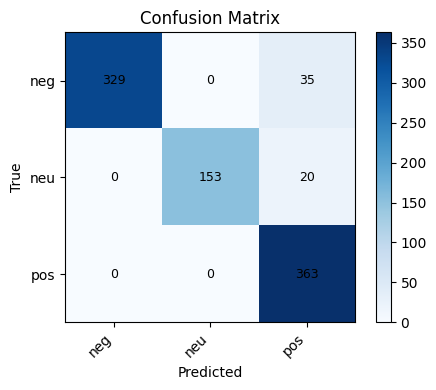

✅ Saved model & tokenizer to: /content/workdir/mbert_cls

== Demo inference ==
[{'label': 'pos', 'prob': 0.8975492119789124}, {'label': 'neg', 'prob': 0.9987984895706177}, {'label': 'neu', 'prob': 0.998197615146637}]


In [ ]:
# ============================================================
# mBERT (PyTorch, 🤗 Transformers) → fine-tune Sentiment/Topic
# - No TensorFlow / No tf-keras / No tensorflow-text
# - Robust text/label detection + weak-label (VADER) fallback
# - Fixed: WeightedTrainer (override compute_loss) — no TypeError
# ============================================================

# 0) Gỡ sạch các gói TF gây xung đột (nếu có)
!pip -q uninstall -y tensorflow tensorflow-text tf-keras tensorflow-decision-forests keras-hub dopamine-rl > /dev/null 2>&1 || true

# 1) Cài libs cho PyTorch pipeline (pin version để reproducible)
!pip -q install \
  "torch==2.3.1" "accelerate==0.33.0" \
  "transformers==4.44.2" "datasets==2.21.0" "evaluate==0.4.2" \
  "scikit-learn==1.6.1" "pandas==2.2.2" "matplotlib==3.9.0" \
  "vaderSentiment==3.3.2" > /dev/null

# -------------------- PYTHON CODE --------------------
import os, re, json, math, sys
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments, set_seed,
                          DataCollatorWithPadding)

# -------- Paths --------
CANDIDATES = [
    "/content/Social Media Engagement Dataset.csv",
    "/mnt/data/Social Media Engagement Dataset.csv"
]
DATA_SRC = next((p for p in CANDIDATES if Path(p).exists()), CANDIDATES[0])

WORKDIR = Path("/content/workdir"); WORKDIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR = WORKDIR / "mbert_cls"  # nơi save_pretrained()
LABEL_MAP_JSON = WORKDIR / "label_map.json"

set_seed(42)

# -------- Utils --------
def norm_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ","_") for c in df.columns]
    return df

def basic_clean(s: str) -> str:
    return re.sub(r"\s+", " ", str(s or "")).strip()

def detect_text_and_label(df: pd.DataFrame):
    cols = set(df.columns)
    # exact matches trước
    text_candidates_exact = [
        "text","content","caption","message","body","post","comment","title","description",
        "noi_dung","mo_ta","binh_luan","status","review","headline","summary",
        "text_content","post_text","tweet_text"
    ]
    label_candidates = [
        "label","labels","sentiment","sentiment_label","target","topic","category","class","tag"
    ]
    text_col = next((c for c in text_candidates_exact if c in cols), None)
    label_col = next((c for c in label_candidates if c in cols), None)
    # fallback: so khớp "chứa chuỗi"
    if text_col is None:
        tokens = ["text","content","caption","message","body","review","description","status","comment","post"]
        text_col = next((c for c in df.columns if any(tok in c for tok in tokens)), None)
    return text_col, label_col

def synthesize_text(df: pd.DataFrame) -> pd.Series:
    # ghép các cột chuỗi (trừ _id & thời gian) thành 1 text
    time_like = [c for c in df.columns if any(k in c for k in ["time","date","created","timestamp","posted","day"])]
    string_cols = [c for c in df.columns
                   if df[c].dtype == "object" and not c.endswith("_id") and c not in time_like]
    if not string_cols:
        string_cols = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
    return df[string_cols].astype(str).apply(
        lambda row: " ".join([basic_clean(x) for x in row if str(x).strip()]), axis=1
    )

def standardize_label(x: str):
    s = str(x).strip().lower()
    mapping = {
        "positive":"pos","pos":"pos","+":"pos","1":"pos","like":"pos","good":"pos","tích_cực":"pos",
        "negative":"neg","neg":"neg","-":"neg","-1":"neg","dislike":"neg","bad":"neg","tiêu_cực":"neg",
        "neutral":"neu","neu":"neu","0":"neu","neutral/other":"neu","trung_lập":"neu"
    }
    return mapping.get(s, s)

def plot_cm(cm, labels):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right"); ax.set_yticklabels(labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j], ha="center", va="center", fontsize=9)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix")
    plt.colorbar(im, ax=ax); plt.tight_layout(); plt.show()

# -------- Load --------
if not Path(DATA_SRC).exists():
    try:
        from google.colab import files
        print("Không thấy CSV — vui lòng upload")
        uploaded = files.upload()
        DATA_SRC = "/content/" + next(iter(uploaded.keys()))
    except Exception as e:
        raise FileNotFoundError("Không tìm thấy file CSV và không thể mở prompt upload.") from e

df = pd.read_csv(DATA_SRC)
df = norm_cols(df)

# -------- Prepare text --------
text_col, label_col = detect_text_and_label(df)
if text_col is None:
    df["__text"] = synthesize_text(df); text_col = "__text"
else:
    df[text_col] = df[text_col].astype(str).map(basic_clean)
df = df[df[text_col].str.len() > 0].reset_index(drop=True)

# -------- Prepare labels (prefer real labels; else weak VADER sentiment) --------
sent_keywords = {"pos","neg","neu","positive","negative","neutral"}
if label_col and df[label_col].notna().sum() > 0:
    y_raw = df[label_col].astype(str).map(standardize_label)
    classes = sorted(y_raw.dropna().unique().tolist())
    task = "sentiment" if (set(classes) & sent_keywords and len(classes) <= 6) else "topic"
    y = y_raw.fillna("unknown")
else:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    def vader_label(s):
        vs = analyzer.polarity_scores(s)["compound"]
        if vs >= 0.05: return "pos"
        elif vs <= -0.05: return "neg"
        else: return "neu"
    y = df[text_col].map(vader_label); task = "sentiment"

y = y.astype(str)
label_vocab = sorted(pd.Series(y).unique().tolist())
label2id = {l:i for i,l in enumerate(label_vocab)}
id2label = {i:l for l,i in label2id.items()}
json.dump({"label2id":label2id, "id2label":id2label, "task":task}, open(LABEL_MAP_JSON,"w"), ensure_ascii=False, indent=2)

df_model = pd.DataFrame({text_col: df[text_col], "label": pd.Series(y).map(label2id)})

# -------- Cap per class (KHÔNG dùng groupby.apply) --------
CAP_PER_CLASS = 30000
df_model = df_model.sort_values("label").reset_index(drop=True)
df_model["__rank"] = df_model.groupby("label").cumcount()
df_model = df_model[df_model["__rank"] < CAP_PER_CLASS].drop(columns="__rank").reset_index(drop=True)

# -------- Split --------
train_df, test_df = train_test_split(df_model, test_size=0.15, random_state=42, stratify=df_model["label"])
val_df,   test_df = train_test_split(test_df, test_size=0.5,  random_state=42, stratify=test_df["label"])

# -------- Tokenizer & torch Dataset --------
MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 128

class TextClsDS(Dataset):
    def __init__(self, df, text_col, tokenizer, max_len):
        self.x = df[text_col].astype(str).tolist()
        self.y = df["label"].astype(int).tolist()
        self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.x)
    def __getitem__(self, idx):
        # dynamic padding via DataCollator → không padding ở đây
        enc = self.tok(self.x[idx], truncation=True, max_length=self.max_len, return_tensors=None)
        enc["labels"] = self.y[idx]
        return enc

train_ds = TextClsDS(train_df, text_col, tokenizer, MAX_LEN)
val_ds   = TextClsDS(val_df,   text_col, tokenizer, MAX_LEN)
test_ds  = TextClsDS(test_df,  text_col, tokenizer, MAX_LEN)

collator = DataCollatorWithPadding(tokenizer=tokenizer)

# -------- Model --------
num_labels = len(label_vocab)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=num_labels, id2label=id2label, label2id=label2id
)
# Cảnh báo "Some weights ... newly initialized" là bình thường (classifier head khởi tạo mới).

# -------- Class weights (đối phó lệch lớp) --------
counts = train_df["label"].value_counts().sort_index().values
weights = torch.tensor((counts.sum() / (len(counts) * counts)), dtype=torch.float)

# -------- Weighted Trainer (override compute_loss) --------
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        if self.class_weights is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# -------- TrainingArguments --------
# Tự chọn bf16/fp16 theo GPU Colab
use_cuda = torch.cuda.is_available()
bf16 = False; fp16 = False
if use_cuda:
    major, minor = torch.cuda.get_device_capability()
    if major >= 8:  # Ampere+ → bf16
        bf16 = True
    else:
        fp16 = True

BATCH = 16
EPOCHS = 3
args = TrainingArguments(
    output_dir=str(WORKDIR / "runs"),
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    num_train_epochs=EPOCHS,
    learning_rate=3e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=50,
    save_total_limit=2,
    report_to="none",
    fp16=fp16,
    bf16=bf16
)

def compute_metrics(eval_pred):
    # Hỗ trợ EvalPrediction hoặc tuple
    if hasattr(eval_pred, "predictions"):
        logits, labels = eval_pred.predictions, eval_pred.label_ids
    else:
        logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = float((preds == labels).mean())
    f1m = float(f1_score(labels, preds, average="macro"))
    return {"accuracy": acc, "f1_macro": f1m}

trainer = WeightedTrainer(
    class_weights=weights,
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics
)

print("== Start training ==")
trainer.train()

# -------- Evaluate on test --------
print("\n== Evaluate on test set ==")
preds = trainer.predict(test_ds)
y_pred = preds.predictions.argmax(axis=-1)
y_true = preds.label_ids if getattr(preds, "label_ids", None) is not None else np.array(test_df["label"].tolist())

target_names = [id2label[i] for i in range(num_labels)]
print("== Classification report ==")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_labels)))
plot_cm(cm, target_names)

# -------- Save model & tokenizer --------
MODEL_DIR.mkdir(parents=True, exist_ok=True)
trainer.model.save_pretrained(str(MODEL_DIR))
tokenizer.save_pretrained(str(MODEL_DIR))
print("✅ Saved model & tokenizer to:", MODEL_DIR)

# -------- Inference helper --------
def predict_text(texts):
    mdl = trainer.model
    mdl.eval()
    enc = tokenizer(list(map(basic_clean, texts)), truncation=True, padding=True,
                    max_length=MAX_LEN, return_tensors="pt")
    device = next(mdl.parameters()).device
    with torch.no_grad():
        out = mdl(**{k: v.to(device) for k,v in enc.items()})
        probs = torch.softmax(out.logits, dim=-1).cpu().numpy()
        idx = probs.argmax(axis=-1)
    return [{"label": id2label[int(i)], "prob": float(probs[j, int(i)])}
            for j,i in enumerate(idx)]

print("\n== Demo inference ==")
print(predict_text([
    "Sản phẩm rất tuyệt vời, sẽ mua lại!",
    "Tệ quá, không khuyến nghị.",
    "Bình thường, không có gì nổi bật."
]))


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tensorstore 0.1.78 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
jax 0.7.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
Using text_col=__text | num_feats=['likes_count', 'shares_count', 'comments_count', 'impressions'] | rows=12000


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_in             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_vec             │ (None, 64)        │          0 │ text_in[0][0]     │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 4)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb (Embedding)     │ (None, 64, 64)    │  1,920,000 │ seq_vec[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ emb[0][0]         │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_norm            │ (None, 4)         │          9 │ num_in[0][0]      │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 68)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ num_norm[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │      8,832 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wide_tfidf          │ (None, 10893)     │          0 │ text_in[0][0]     │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wide_concat         │ (None, 10897)     │          0 │ wide_tfidf[0][0], │
│ (Concatenate)       │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wide_logit (Dense)  │ (None, 1)         │     10,897 │ wide_concat[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_logit (Dense)  │ (None, 1)         │         65 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sum (Add)           │ (None, 1)         │          0 │ wide_logit[0][0], │
│                     │                   │            │ deep_logit[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,948,059 (7.43 MB)

 Trainable params: 1,948,050 (7.43 MB)

 Non-trainable params: 9 (40.00 B)

Epoch 1/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 10785514.0000 - mae: 2853.2834 - val_loss: 3946650.5000 - val_mae: 1636.8888
Epoch 2/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3565347.7500 - mae: 1534.9713 - val_loss: 2196358.5000 - val_mae: 1229.4261
Epoch 3/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2134443.7500 - mae: 1212.3054 - val_loss: 1661246.5000 - val_mae: 1072.0543
Epoch 4/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1685808.0000 - mae: 1085.6084 - val_loss: 1418390.7500 - val_mae: 991.9081
Epoch 5/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1437039.8750 - mae: 1004.0595 - val_loss: 1191467.1250 - val_mae: 911.2189
Epoch 6/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1183539.8750 - mae: 914.3050 - val_loss: 950519.3750 - val_mae: 813.0306
Epoch 7/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 936401.8750 - mae: 812.0964 - val_loss: 693134.7500 - val_mae: 698.8029
Epoch 8/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 669600.1875 

/tmp/ipython-input-1765546166.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[c] = pd.to_numeric(train_df[c], errors="coerce").astype("float32")
/tmp/ipython-input-1765546166.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[c]   = pd.to_numeric(val_df[c],   errors="coerce").astype("float32")
/tmp/ipython-input-1765546166.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141435
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 2729
[LightGBM] [Info] Start training from score 3999.628125


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[GBDT]  Val  MAE=32.0613, R2=0.9993
[GBDT]  Test MAE=31.3377, R2=0.9994


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 18237516.0000 - mae: 3972.5645 - val_loss: 18569884.0000 - val_mae: 4020.9783
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18728226.0000 - mae: 4027.0525 - val_loss: 18525190.0000 - val_mae: 4015.6392
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18251922.0000 - mae: 3972.7170 - val_loss: 18414382.0000 - val_mae: 4003.1370
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18198944.0000 - mae: 3965.7317 - val_loss: 18183544.0000 - val_mae: 3977.9468
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18231298.0000 - mae: 3974.7048 - val_loss: 17779194.0000 - val_mae: 3934.4009
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17666046.0000 - mae: 3915.6931 - val_loss: 17156274.0000 - val_mae: 3867.2183
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16611033.0000 - mae: 3787.9895 - val_loss: 16279695.0000 - val_mae: 3771.5674
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

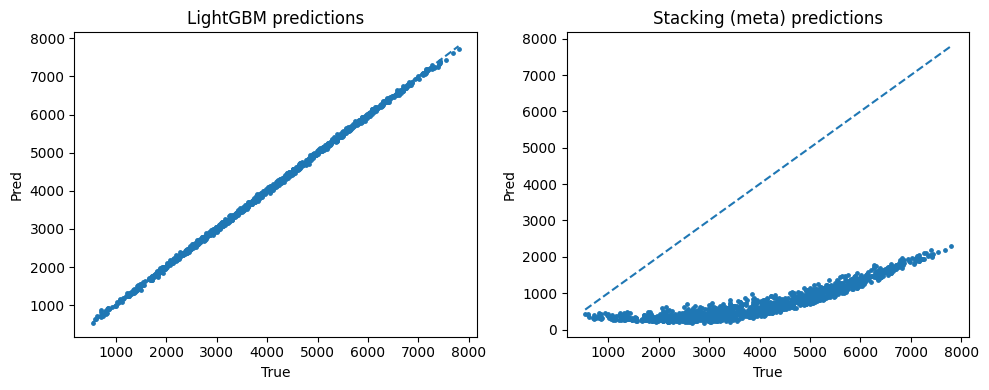

In [ ]:
# ============================================================
# DỰ BÁO TƯƠNG TÁC: Keras Wide&Deep + GBDT-Stacking (LightGBM)
# Target: engagement = likes + shares + comments (regression)
# Text đặc trưng: Keras TextVectorization & TF-IDF
# ============================================================

# Cài gói (không cài tensorflow-text / tf-hub để né xung đột)
!pip -q install "tensorflow==2.18.0" "scikit-learn==1.6.1" "pandas==2.2.2" \
                "lightgbm==4.5.0" "matplotlib==3.9.0" > /dev/null

import os, re
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
import lightgbm as lgb

import tensorflow as tf
from tensorflow.keras import layers, Model

# ---------------- Paths ----------------
CANDIDATES = [
    "/content/Social Media Engagement Dataset.csv",
    "/mnt/data/Social Media Engagement Dataset.csv"
]
DATA_SRC = next((p for p in CANDIDATES if Path(p).exists()), CANDIDATES[0])
WORKDIR = Path("/content/workdir"); WORKDIR.mkdir(parents=True, exist_ok=True)
WIDE_DEEP_OUT = WORKDIR / "wide_deep_engagement.keras"
STACK_OUT     = WORKDIR / "stack_meta.keras"

# ---------------- Utils ----------------
def norm_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ","_") for c in df.columns]
    return df

def detect_cols(df):
    cols = set(df.columns)
    likes    = next((c for c in ["likes_count","likes"] if c in cols), None)
    shares   = next((c for c in ["shares_count","shares","retweets"] if c in cols), None)
    comments = next((c for c in ["comments_count","comments","replies"] if c in cols), None)
    imps     = next((c for c in ["impressions","views","view_count","reach"] if c in cols), None)
    time_col = next((c for c in df.columns if any(k in c for k in ["time","date","created","timestamp","posted"])), None)
    # text
    text_col = next((c for c in ["text","content","caption","message","body","post","comment","title","description",
                                 "noi_dung","mo_ta","binh_luan","status","review","headline","summary"] if c in cols), None)
    return likes, shares, comments, imps, text_col, time_col

def basic_clean(s: str) -> str:
    return re.sub(r"\s+", " ", str(s or "")).strip()

def synthesize_text(df: pd.DataFrame) -> pd.Series:
    time_like = [c for c in df.columns if any(k in c for k in ["time","date","created","timestamp","posted","day"])]
    string_cols = [c for c in df.columns
                   if df[c].dtype == "object" and not c.endswith("_id") and c not in time_like]
    if not string_cols:
        string_cols = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
    return df[string_cols].astype(str).apply(
        lambda row: " ".join([basic_clean(x) for x in row if str(x).strip()]), axis=1
    )

# ---------------- Load ----------------
if not Path(DATA_SRC).exists():
    from google.colab import files
    print("Không thấy CSV — vui lòng upload")
    uploaded = files.upload()
    DATA_SRC = "/content/" + next(iter(uploaded.keys()))

df = pd.read_csv(DATA_SRC)
df = norm_cols(df)

likes_col, shares_col, comments_col, imps_col, text_col, time_col = detect_cols(df)

# Build target & numeric features
for c in [likes_col, shares_col, comments_col, imps_col]:
    if c and df[c].dtype == "object":
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(",","", regex=False), errors="coerce")

# target = likes + shares + comments
parts = []
if likes_col:    parts.append(df[likes_col].fillna(0.0))
if shares_col:   parts.append(df[shares_col].fillna(0.0))
if comments_col: parts.append(df[comments_col].fillna(0.0))
if not parts:
    raise RuntimeError("Không tìm thấy cột likes/shares/comments để tạo target 'engagement'.")
df["engagement"] = (sum(parts)).astype("float32")

# text
if not text_col:
    df["__text"] = synthesize_text(df); text_col = "__text"
else:
    df[text_col] = df[text_col].astype(str).map(basic_clean)

# Lọc các hàng text rỗng
df = df[df[text_col].astype(str).str.len() > 0].reset_index(drop=True)

# numeric feature list (đặt thiếu thì bỏ qua)
num_feats = [c for c in [likes_col, shares_col, comments_col, imps_col] if c]
print(f"Using text_col={text_col} | num_feats={num_feats} | rows={len(df)}")

# ---------------- Split (time-aware nếu có cột thời gian) ----------------
if time_col and time_col in df.columns:
    ts = pd.to_datetime(df[time_col], errors="coerce", utc=True)
    df = df.assign(__ts=ts).sort_values("__ts").reset_index(drop=True)
    n = len(df)
    train_df = df.iloc[: int(0.8*n)]
    val_df   = df.iloc[int(0.8*n): int(0.9*n)]
    test_df  = df.iloc[int(0.9*n): ]
else:
    train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
    train_df, val_df  = train_test_split(train_df, test_size=0.1111, random_state=42)  # ~0.1 tổng
    for d in (train_df, val_df, test_df):
        d.reset_index(drop=True, inplace=True)

# ========== 1) KERAS WIDE & DEEP ==========
MAX_TOKENS = 30000
SEQ_LEN    = 64

# Keras datasets
def make_tf_ds(df_in, text_col, num_feats, batch=128, shuffle=False):
    x_text = tf.constant(df_in[text_col].astype(str).tolist())
    x_num  = tf.convert_to_tensor(df_in[num_feats].fillna(0.0).values, dtype=tf.float32)
    y      = tf.convert_to_tensor(df_in["engagement"].values, dtype=tf.float32)
    ds = tf.data.Dataset.from_tensor_slices(((x_text, x_num), y))
    if shuffle: ds = ds.shuffle(min(len(df_in), 10000), seed=42)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

train_ds = make_tf_ds(train_df, text_col, num_feats, shuffle=True)
val_ds   = make_tf_ds(val_df, text_col, num_feats)
test_ds  = make_tf_ds(test_df, text_col, num_feats)

# Vectorizers & Normalization (fit trên train)
wide_text_vec = layers.TextVectorization(
    max_tokens=MAX_TOKENS, output_mode="tf_idf", ngrams=2, name="wide_tfidf"
)
wide_text_vec.adapt(train_df[text_col].astype(str))

seq_vec = layers.TextVectorization(
    max_tokens=MAX_TOKENS, output_mode="int", output_sequence_length=SEQ_LEN, name="seq_vec"
)
seq_vec.adapt(train_df[text_col].astype(str))

num_norm = layers.Normalization(name="num_norm")
num_norm.adapt(train_df[num_feats].fillna(0.0).values)

# --- Build Keras graph (2 Input: text_in, num_in) ---
text_in  = layers.Input(shape=(), dtype=tf.string,   name="text_in")
num_in   = layers.Input(shape=(len(num_feats),), dtype=tf.float32, name="num_in")

# Wide path: TF-IDF (n-gram) + numeric tuyến tính
wide_text = wide_text_vec(text_in)                      # (batch, vocab)
wide_num  = num_in                                      # (batch, n_num)
wide_cat  = layers.Concatenate(name="wide_concat")([wide_text, wide_num])
wide_out  = layers.Dense(1, use_bias=False, name="wide_logit")(wide_cat)

# Deep path: Text seq → Embedding → GAP + normalized numeric → MLP
seq_ids = seq_vec(text_in)                              # (batch, SEQ_LEN)
emb     = layers.Embedding(input_dim=MAX_TOKENS, output_dim=64, name="emb")(seq_ids)
txt_vec = layers.GlobalAveragePooling1D()(emb)
num_vec = num_norm(num_in)
deep    = layers.Concatenate()([txt_vec, num_vec])
deep    = layers.Dense(128, activation="relu")(deep)
deep    = layers.Dropout(0.2)(deep)
deep    = layers.Dense(64, activation="relu")(deep)
deep_out= layers.Dense(1, name="deep_logit")(deep)

# Tổng hợp
out = layers.Add(name="sum")([wide_out, deep_out])

model_wd = Model(inputs={"text_in": text_in, "num_in": num_in}, outputs=out)
model_wd.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                 loss="mse",
                 metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")])
model_wd.summary()

# --- Data mapping function (FIXED SIGNATURE) ---
def map_batch_wide_deep(x, y):
    x_text, x_num = x  # x là tuple (x_text, x_num)
    feed = {"text_in": x_text, "num_in": x_num}
    return feed, y

train_ds_wd = (train_ds
               .map(map_batch_wide_deep, num_parallel_calls=tf.data.AUTOTUNE)
               .prefetch(tf.data.AUTOTUNE))
val_ds_wd   = (val_ds
               .map(map_batch_wide_deep, num_parallel_calls=tf.data.AUTOTUNE)
               .prefetch(tf.data.AUTOTUNE))
test_ds_wd  = (test_ds
               .map(map_batch_wide_deep, num_parallel_calls=tf.data.AUTOTUNE)
               .prefetch(tf.data.AUTOTUNE))

cb = [tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor="val_mae")]
hist = model_wd.fit(train_ds_wd, validation_data=val_ds_wd, epochs=8, verbose=1, callbacks=cb)

loss, mae = model_wd.evaluate(test_ds_wd, verbose=0)
print(f"[Wide&Deep] Test MAE={mae:.4f}")

model_wd.save(str(WIDE_DEEP_OUT))
print("✅ Saved Wide&Deep:", WIDE_DEEP_OUT)

# ========== 2) GBDT STACKING (LightGBM base + Keras meta) ==========
# Khắc phục lỗi dtype: Imputer(fill_value=0) + ép float32
for c in num_feats:
    train_df[c] = pd.to_numeric(train_df[c], errors="coerce").astype("float32")
    val_df[c]   = pd.to_numeric(val_df[c],   errors="coerce").astype("float32")
    test_df[c]  = pd.to_numeric(test_df[c],  errors="coerce").astype("float32")

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)

num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="constant", fill_value=0, keep_empty_features=True)),  # 0 (int) để không vấp cast
    ("tofloat", FunctionTransformer(lambda X: X.astype(np.float32))),                     # ép float32 ngay sau impute
    ("sc", StandardScaler(with_mean=False))                                               # với sparse
])

preproc = ColumnTransformer(
    transformers=[
        ("tfidf", tfidf, text_col),
        ("num",   num_pipe, num_feats),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

lgbm = lgb.LGBMRegressor(
    n_estimators=800, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
    max_depth=-1, num_leaves=63, random_state=42
)
pipe = Pipeline([("prep", preproc), ("lgbm", lgbm)])

X_train = train_df[[text_col] + num_feats]
y_train = train_df["engagement"].values.astype("float32")
X_val   = val_df[[text_col] + num_feats]
y_val   = val_df["engagement"].values.astype("float32")
X_test  = test_df[[text_col] + num_feats]
y_test  = test_df["engagement"].values.astype("float32")

pipe.fit(X_train, y_train)
pred_lgb_val  = pipe.predict(X_val)
pred_lgb_test = pipe.predict(X_test)

print(f"[GBDT]  Val  MAE={mean_absolute_error(y_val, pred_lgb_val):.4f}, R2={r2_score(y_val, pred_lgb_val):.4f}")
print(f"[GBDT]  Test MAE={mean_absolute_error(y_test, pred_lgb_test):.4f}, R2={r2_score(y_test, pred_lgb_test):.4f}")

# Keras meta-learner: nhận [numeric, yhat_lgb] -> MLP nhỏ
def make_meta_inputs(df_in, preds):
    num = df_in[num_feats].fillna(0.0).values.astype("float32")
    preds = preds.astype("float32").reshape(-1,1)
    return np.concatenate([num, preds], axis=1)

Xval_meta  = make_meta_inputs(val_df,  pred_lgb_val)
Xtest_meta = make_meta_inputs(test_df, pred_lgb_test)
Xtrain_meta= make_meta_inputs(train_df, pipe.predict(X_train).astype("float32"))  # (đơn giản; có thể thay bằng OOF)

ytrain = y_train.astype("float32"); yval = y_val.astype("float32"); ytest = y_test.astype("float32")

norm_meta = layers.Normalization()
norm_meta.adapt(Xtrain_meta)

meta_in = layers.Input(shape=(Xtrain_meta.shape[1],))
x = norm_meta(meta_in)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
meta_out = layers.Dense(1)(x)
meta = Model(meta_in, meta_out)
meta.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")])

cb2 = [tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor="val_mae")]
meta.fit(Xtrain_meta, ytrain, validation_data=(Xval_meta, yval), epochs=10, batch_size=256, callbacks=cb2, verbose=1)

yhat_stack = meta.predict(Xtest_meta, verbose=0).reshape(-1)
print(f"[Stack] Test MAE={mean_absolute_error(ytest, yhat_stack):.4f}, R2={r2_score(ytest, yhat_stack):.4f}")

meta.save(str(STACK_OUT))
print("✅ Saved Stacking meta:", STACK_OUT)

# --------- Quick plots ---------
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(y_test, pred_lgb_test, s=6); ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], ls="--")
ax[0].set_title("LightGBM predictions"); ax[0].set_xlabel("True"); ax[0].set_ylabel("Pred")
ax[1].scatter(y_test, yhat_stack, s=6); ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], ls="--")
ax[1].set_title("Stacking (meta) predictions"); ax[1].set_xlabel("True"); ax[1].set_ylabel("Pred")
plt.tight_layout(); plt.show()


In [ ]:
# ============================================================
# GỢI Ý THỜI ĐIỂM ĐĂNG CHO BẤT KỲ HASHTAG (1 cell duy nhất)
# - Xây P(slot | hashtag) từ lịch sử engagement (likes+comments+shares)
# - Dò hashtag linh hoạt: cột hashtags/tags hoặc trích từ caption/text
# - Fallback prefix & toàn cục; hỗ trợ pha trộn P(slot|user)
# ============================================================

import ast, json, re
from pathlib import Path
import numpy as np
import pandas as pd

# ------------ Cấu hình ------------
CANDIDATES = [
    "/content/Social Media Engagement Dataset.csv",
    "/mnt/data/Social Media Engagement Dataset.csv"
]
DATA_SRC = next((p for p in CANDIDATES if Path(p).exists()), CANDIDATES[0])

SLOT_BIN  = "hour"   # "hour" (0..23) hoặc "2h" (12 bin)
SMOOTH_A  = 1.0      # additive smoothing cho mọi phân phối
USER_BLEND = 0.3     # nếu truyền user: p = (1-USER_BLEND)*P(slot|tag) + USER_BLEND*P(slot|user)

# ------------ Tiện ích ------------
def norm_cols(df): return df.rename(columns=lambda c: c.strip().lower().replace(" ","_"))

def detect_cols(df):
    cols = set(df.columns)
    likes    = next((c for c in ["likes_count","likes"] if c in cols), None)
    shares   = next((c for c in ["shares_count","shares","retweets"] if c in cols), None)
    comments = next((c for c in ["comments_count","comments","replies"] if c in cols), None)
    user     = next((c for c in ["user_id","userid","author_id","username","user","creator_id","account_id"] if c in cols), None)
    time_col = next((c for c in df.columns if any(k in c for k in ["time","date","created","timestamp","posted"])), None)
    text     = next((c for c in ["text","content","caption","message","body","post","comment","title","description",
                                 "noi_dung","mo_ta","binh_luan","status","review","headline","summary"] if c in cols), None)
    return likes, shares, comments, user, time_col, text

def to_float_cols(df, cols):
    for c in cols:
        if c and df[c].dtype == "object":
            df[c] = pd.to_numeric(df[c].astype(str).str.replace(",","", regex=False), errors="coerce")
    return df

def make_time_slot(ts: pd.Series, mode="hour"):
    if mode == "hour":  # 24 bins
        return ts.dt.hour.fillna(-1).astype(int)
    elif mode == "2h":  # 12 bins
        return (ts.dt.hour.fillna(-1).astype(int) // 2).astype(int)
    else:
        return ts.dt.hour.fillna(-1).astype(int)

# ---------- Hashtag extraction (vá đầy đủ) ----------
HASHTAG_TEXT_REGEX = re.compile(r"#([^\s#]+)", re.UNICODE)

def extract_hashtags_from_text(s: str):
    if not isinstance(s, str): return []
    tags = [t.strip(".,;:!?)]}”“\"'").lower() for t in HASHTAG_TEXT_REGEX.findall(s)]
    return [t for t in tags if t and len(t) >= 2]

def parse_hashtag_field(x):
    if x is None: return []
    if isinstance(x, list):
        return [str(t).lower().lstrip("#").strip() for t in x if str(t).strip()]
    s = str(x).strip()
    if not s: return []
    # JSON / Python list?
    if (s.startswith("[") and s.endswith("]")) or (s.startswith("(") and s.endswith(")")):
        try:
            arr = json.loads(s)
        except Exception:
            try:
                arr = ast.literal_eval(s)
            except Exception:
                arr = None
        if isinstance(arr, (list, tuple)):
            return [str(t).lower().lstrip("#").strip() for t in arr if str(t).strip()]
    # Tách theo dấu phẩy, chấm phẩy, pipe, khoảng trắng
    parts = re.split(r"[,\;\|\s]+", s)
    return [p.lower().lstrip("#").strip() for p in parts if p.strip()]

def detect_hashtag_source_cols(df):
    # Ưu tiên tên “rõ ràng”
    cand_exact = [c for c in df.columns if c.lower() in {
        "hashtags","hash_tags","tags","tag_list","topic_tags","hash_tag"
    }]
    if cand_exact: return cand_exact
    # Nếu không, tìm tên “có chứa”
    cand_contains = [c for c in df.columns if any(k in c.lower() for k in
                    ["hashtag","hash_tag","tags","tag"])]
    return cand_contains

def build_hashtags_list(df, text_col, fallback_to_text=True):
    tag_cols = detect_hashtag_source_cols(df)
    if tag_cols:
        col = tag_cols[0]
        h = df[col].apply(parse_hashtag_field)
        if fallback_to_text and (h.map(len).sum() == 0) and (text_col and text_col in df.columns):
            h = df[text_col].astype(str).map(extract_hashtags_from_text)
        return h, col
    else:
        if text_col and text_col in df.columns:
            return df[text_col].astype(str).map(extract_hashtags_from_text), text_col
        return pd.Series([[] for _ in range(len(df))], index=df.index), None

def format_slot(s, mode="hour"):
    if mode == "hour":
        return f"{int(s):02d}:00"
    lo = 2*int(s); hi = lo + 2
    return f"{lo:02d}:00–{hi:02d}:00"

# ------------ Nạp dữ liệu ------------
if not Path(DATA_SRC).exists():
    from google.colab import files
    print("Không thấy CSV — vui lòng upload")
    uploaded = files.upload()
    DATA_SRC = "/content/" + next(iter(uploaded.keys()))

df = pd.read_csv(DATA_SRC)
df = norm_cols(df)

likes, shares, comments, user_col, time_col, text_col = detect_cols(df)
if not any([likes, shares, comments]):
    raise RuntimeError("Không tìm thấy likes/shares/comments để tính engagement.")

df = to_float_cols(df, [likes, shares, comments])
df["engagement"] = sum(df[c].fillna(0.0) for c in [likes, shares, comments] if c)

# user id (fallback 'global' nếu không có cột user)
if user_col and user_col in df.columns:
    df["user_id_str"] = df[user_col].astype(str).fillna("nan")
else:
    df["user_id_str"] = "global"

# thời gian → slot
if time_col and time_col in df.columns:
    ts = pd.to_datetime(df[time_col], errors="coerce", utc=True)
else:
    ts = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns, UTC]")

SLOT_LABELS = list(range(24)) if SLOT_BIN == "hour" else list(range(12))
df["slot"] = make_time_slot(ts, SLOT_BIN)
valid_time = df["slot"] >= 0

# hashtags list (vá)
df["hashtags_list"], hashtag_src = build_hashtags_list(df, text_col, fallback_to_text=True)

# Thống kê nhanh
total_rows = len(df)
rows_with_tags = int((df["hashtags_list"].map(len) > 0).sum())
unique_tags = sorted({t for lst in df["hashtags_list"] for t in lst})
print(f"Hashtag source = {hashtag_src or '(auto)'} | rows_with_tags = {rows_with_tags}/{total_rows} | unique_tags = {len(unique_tags)}")

# ------------ P(slot | hashtag) ------------
rows = []
for _, r in df[valid_time].iterrows():
    slot = int(r["slot"])
    tags = r["hashtags_list"]
    if not tags:
        continue
    share = float(r["engagement"]) / max(len(tags), 1)  # chia đều nếu nhiều hashtag
    for t in tags:
        rows.append((t, slot, share))

tag_slot_df = pd.DataFrame(rows, columns=["tag","slot","eng_part"])

# Phân phối toàn cục P(slot)
global_slot = (df[valid_time]
               .groupby("slot", as_index=False)["engagement"].sum()
               .set_index("slot")["engagement"]
               .reindex(SLOT_LABELS).fillna(0.0).astype(float))
global_probs = (global_slot + SMOOTH_A) / (global_slot.sum() + SMOOTH_A*len(SLOT_LABELS))

# P(slot | user) để pha trộn (nếu cần)
user_slot_prob = {}
if valid_time.any():
    user_agg = (df[valid_time]
                .groupby(["user_id_str","slot"], as_index=False)["engagement"].sum())
    for uid, g in user_agg.groupby("user_id_str"):
        slot_map = {int(r.slot): float(r.engagement) for _, r in g.iterrows()}
        vec = np.array([slot_map.get(s, 0.0) for s in SLOT_LABELS], dtype="float64")
        vec = vec + SMOOTH_A
        user_slot_prob[uid] = vec / vec.sum()
else:
    user_slot_prob["global"] = global_probs.values

# P(slot | hashtag)
if tag_slot_df.empty:
    print("⚠️ Không phát hiện hashtag trong dữ liệu. Sử dụng gợi ý theo phân phối toàn cục.")
    TAG_PROBS = {}
else:
    agg = tag_slot_df.groupby(["tag","slot"], as_index=False)["eng_part"].sum()
    TAG_PROBS = {}
    for tag, g in agg.groupby("tag"):
        slot_map = {int(r.slot): float(r.eng_part) for _, r in g.iterrows()}
        vec = np.array([slot_map.get(s, 0.0) for s in SLOT_LABELS], dtype="float64")
        vec = vec + SMOOTH_A
        TAG_PROBS[tag] = vec / vec.sum()

# ------------ API: gợi ý khung giờ cho hashtag ------------
def suggest_times_for_hashtag(tag_input: str, topk=5, user: str | None = None):
    """
    tag_input: '#Travel' hoặc 'travel'
    user: nếu truyền và có thống kê -> pha trộn với P(slot|user)
    """
    if not isinstance(tag_input, str) or not tag_input.strip():
        raise ValueError("Hashtag trống.")
    tag = tag_input.strip().lower()
    if tag.startswith("#"): tag = tag[1:]

    # 1) P(slot|tag)
    if tag in TAG_PROBS:
        p_tag = TAG_PROBS[tag]
    else:
        # fallback prefix >=3 ký tự
        pref = tag[:max(3, min(3, len(tag)))]
        cands = [t for t in TAG_PROBS.keys() if t.startswith(pref)]
        if cands:
            p_tag = np.mean([TAG_PROBS[t] for t in cands], axis=0)
            p_tag = p_tag / p_tag.sum()
        else:
            p_tag = global_probs.values

    # 2) Pha trộn với P(slot|user) nếu có
    if user and (user in user_slot_prob):
        p_user = user_slot_prob[user]
        p = (1-USER_BLEND)*p_tag + USER_BLEND*p_user
    else:
        p = p_tag

    # 3) Lấy top-k
    order = np.argsort(-p)[:topk]
    return [(format_slot(SLOT_LABELS[i], SLOT_BIN), float(p[i])) for i in order]

# ------------ DEMO ------------
sample_tag = "#Fitness"   # thay thử hashtag bạn muốn
print("Ví dụ: Top thời điểm cho #Fitness", suggest_times_for_hashtag(sample_tag, topk=5))

# Thử in top vài hashtag đã thấy (nếu có)
if TAG_PROBS:
    some = list(TAG_PROBS.keys())[:4]
    for t in some:
        print(f"Top thời điểm cho #{t}:", suggest_times_for_hashtag("#"+t, topk=5))
else:
    print("Dataset không có hashtag — đang dùng gợi ý theo phân phối toàn cục.")


Hashtag source = hashtags | rows_with_tags = 12000/12000 | unique_tags = 29
Ví dụ: Top thời điểm cho #Fitness [('02:00', 0.06592886345880553), ('08:00', 0.05248693422916563), ('17:00', 0.05225315332329677), ('19:00', 0.0505843435073737), ('23:00', 0.04743662357576407)]
Top thời điểm cho #affordable: [('19:00', 0.05857541853468256), ('04:00', 0.057100325037543746), ('10:00', 0.05167643583323093), ('05:00', 0.04986500607495381), ('15:00', 0.046306162526445704)]
Top thời điểm cho #beauty: [('06:00', 0.057396391536387134), ('10:00', 0.05569981028486655), ('17:00', 0.054945376791924544), ('03:00', 0.05412076793500099), ('20:00', 0.052745388797131434)]
Top thời điểm cho #bestvalue: [('08:00', 0.05688457432440499), ('02:00', 0.05186927811745084), ('07:00', 0.05012772640972947), ('10:00', 0.04979791574803202), ('11:00', 0.04867949071720812)]
Top thời điểm cho #customerservice: [('12:00', 0.057317494942423844), ('23:00', 0.0515010219324837), ('04:00', 0.049929162682067534), ('08:00', 0.04781550

✅ chế độ dùng: W window=4 (global fallback) | entities=1
Prepared windows: 50 (window=4)
✅ Done. Saved anomalies -> /content/workdir/anomaly_autoencoder.csv
Top 10 anomalies:
    entity                  time_end  recon_error  is_anomaly
0  global 2025-04-27 00:00:00+00:00     1.202991        True
1  global 2025-04-20 00:00:00+00:00     1.004310       False
2  global 2025-05-04 00:00:00+00:00     0.789970       False
3  global 2025-04-13 00:00:00+00:00     0.628572       False
4  global 2025-02-02 00:00:00+00:00     0.538831       False
5  global 2024-10-20 00:00:00+00:00     0.499418       False
6  global 2024-10-13 00:00:00+00:00     0.464482       False
7  global 2025-02-09 00:00:00+00:00     0.426667       False
8  global 2025-01-12 00:00:00+00:00     0.401923       False
9  global 2024-10-06 00:00:00+00:00     0.391604       False
Meta: /content/workdir/anomaly_meta.json


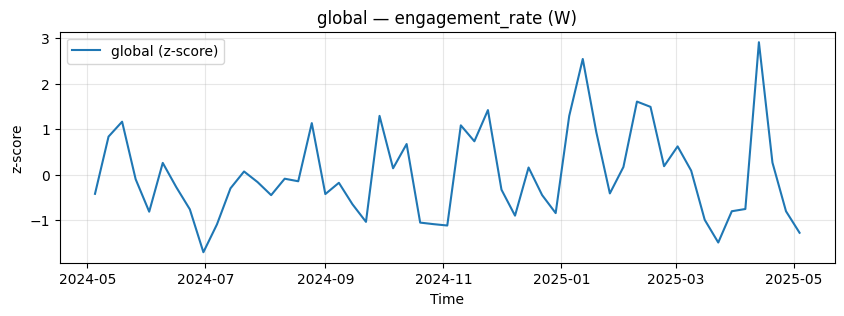

In [ ]:
# ============================================================
# PHÁT HIỆN BẤT THƯỜNG — AUTOENCODER (TỰ THÍCH ỨNG KHI THIẾU DỮ LIỆU)
# - Tự dò likes/shares/comments/impressions/time/user/campaign
# - engagement_rate theo ngày/tuần (auto-fallback)
# - Giảm WINDOW dần → đổi FREQ=tuần → gộp global nếu vẫn thiếu
# ============================================================

!pip -q install "tensorflow==2.18.0" "pandas==2.2.2" "numpy==1.26.4" > /dev/null

import warnings, json
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

warnings.filterwarnings("ignore")

# ---------- Cấu hình cơ bản ----------
CANDIDATES = [
    "/content/Social Media Engagement Dataset.csv",
    "/mnt/data/Social Media Engagement Dataset.csv"
]
DATA_SRC = next((p for p in CANDIDATES if Path(p).exists()), CANDIDATES[0])

WORKDIR = Path("/content/workdir"); WORKDIR.mkdir(parents=True, exist_ok=True)
OUT_CSV   = WORKDIR / "anomaly_autoencoder.csv"
META_JSON = WORKDIR / "anomaly_meta.json"

ENTITY_MODE = "auto"   # "auto" | "user" | "campaign"
FREQ_LIST   = [("D",[14,10,7,5,3]), ("W",[6,5,4,3])]   # chuỗi fallback
STEP        = 1
EPOCHS      = 20
BATCH       = 128
LR          = 3e-3
SEED        = 42
THRESH_Q    = 0.995

tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

# ---------- Helpers ----------
def norm_cols(df): return df.rename(columns=lambda c: c.strip().lower().replace(" ","_"))

def detect_cols(df):
    cols = set(df.columns)
    likes    = next((c for c in ["likes_count","likes"] if c in cols), None)
    shares   = next((c for c in ["shares_count","shares","retweets"] if c in cols), None)
    comments = next((c for c in ["comments_count","comments","replies"] if c in cols), None)
    impr     = next((c for c in ["impressions","views","reach"] if c in cols), None)
    user     = next((c for c in ["user_id","userid","author_id","username","user","creator_id","account_id"] if c in cols), None)
    campaign = next((c for c in ["campaign","campaign_id","adset","adset_id","promotion_id","series","topic"] if c in cols), None)
    tcol     = next((c for c in df.columns if any(k in c for k in ["time","date","created","timestamp","posted"])), None)
    return likes, shares, comments, impr, user, campaign, tcol

def to_num(df, c):
    if not c: return None
    if df[c].dtype == "object":
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(",","", regex=False), errors="coerce")
    return c

def pick_entity_col(df, user, campaign, mode):
    if mode == "user": return user if user in df.columns else None
    if mode == "campaign": return campaign if campaign in df.columns else None
    return campaign or user

def standardize_series(s: pd.Series):
    m, sd = s.mean(skipna=True), s.std(skipna=True)
    if sd and not np.isnan(sd) and sd > 1e-8: return (s - m) / sd
    return s*0.0

def make_windows(series: pd.Series, window=14, step=1):
    vals = series.values.astype("float32")
    X, idx_end = [], []
    for i in range(0, len(vals)-window+1, step):
        seg = vals[i:i+window]
        if np.isnan(seg).any(): continue
        X.append(seg[:,None]); idx_end.append(series.index[i+window-1])
    if not X: return np.empty((0,window,1),dtype="float32"), []
    return np.stack(X,axis=0), idx_end

def build_autoencoder(input_len: int):
    inp = layers.Input(shape=(input_len,1))
    x = layers.Conv1D(32,3,padding="same",activation="relu")(inp)
    x = layers.Conv1D(16,3,padding="same",activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(16,3,padding="same",activation="relu")(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(32,3,padding="same",activation="relu")(x)
    out = layers.Conv1D(1,3,padding="same")(x)
    model = keras.Model(inp,out); model.compile(optimizer=keras.optimizers.Adam(LR), loss="mse")
    return model

def prepare_series(df, entity_col, time_col, freq):
    ser_list = []
    for ent, g in df.groupby(entity_col):
        g = g[[time_col,"engagement_rate"]].dropna().copy()
        if g.empty: continue
        s = (g.set_index(time_col).sort_index().resample(freq)["engagement_rate"].mean())
        s = s.asfreq(freq)  # đảm bảo đều
        s = s.interpolate(limit_direction="both").fillna(0.0)
        ser_list.append((ent, s))
    return ser_list

# ---------- Load ----------
if not Path(DATA_SRC).exists():
    from google.colab import files
    print("Không thấy CSV — vui lòng upload")
    uploaded = files.upload()
    DATA_SRC = "/content/" + next(iter(uploaded.keys()))

df = pd.read_csv(DATA_SRC)
df = norm_cols(df)
likes, shares, comments, impr, user, campaign, tcol = detect_cols(df)
if not any([likes, shares, comments]):
    raise RuntimeError("Thiếu likes/shares/comments — không tính được engagement.")

# numeric
for c in [likes, shares, comments, impr]: to_num(df, c)

df["engagement"] = sum(df[c].fillna(0.0) for c in [likes, shares, comments] if c)
if impr and impr in df.columns:
    df["impr_sane"] = df[impr].clip(lower=1).fillna(1.0)
else:
    fallback = float(pd.to_numeric(df["engagement"], errors="coerce").median(skipna=True) or 1.0)
    df["impr_sane"] = max(1.0, fallback)
df["engagement_rate"] = df["engagement"] / df["impr_sane"]

if not tcol: raise RuntimeError("Không tìm thấy cột thời gian.")
df[tcol] = pd.to_datetime(df[tcol], errors="coerce", utc=True)
df = df.dropna(subset=[tcol]).reset_index(drop=True)

entity_col = pick_entity_col(df, user, campaign, ENTITY_MODE)
if not entity_col:
    entity_col = "_entity_global_"
    df[entity_col] = "global"

# ---------- Auto-adapt tìm cấu hình phù hợp ----------
chosen_freq = None
chosen_window = None
ser_list = []
mode_note = ""

for freq, windows in FREQ_LIST:
    for w in windows:
        tmp_ser = prepare_series(df, entity_col, tcol, freq)
        # lọc entity đủ tối thiểu w điểm
        tmp_ser = [(ent, s) for ent, s in tmp_ser if s.dropna().shape[0] >= w]
        if tmp_ser:
            chosen_freq, chosen_window, ser_list = freq, w, tmp_ser
            mode_note = f"{freq} window={w}"
            break
    if ser_list: break

# Nếu vẫn rỗng, thử gộp global
if not ser_list:
    chosen_freq, chosen_window = "W", 4
    df["_entity_global_"] = "global"
    entity_col = "_entity_global_"
    ser_list = prepare_series(df, entity_col, tcol, chosen_freq)
    ser_list = [(ent, s) for ent, s in ser_list if s.dropna().shape[0] >= chosen_window]
    mode_note = f"{chosen_freq} window={chosen_window} (global fallback)"

if not ser_list:
    raise RuntimeError("Dữ liệu quá ngắn ngay cả với fallback tuần. Hãy tăng khoảng thời gian dữ liệu hoặc giảm window hơn nữa.")

print(f"✅ chế độ dùng: {mode_note} | entities={len(ser_list)}")

# ---------- Windows ----------
X_all, meta_rows = [], []
for ent, s in ser_list:
    s_z = standardize_series(s)
    X, idx_end = make_windows(s_z, chosen_window, STEP)
    if X.shape[0] == 0: continue
    X_all.append(X)
    meta_rows += [(ent, pd.Timestamp(t)) for t in idx_end]

X_all = np.concatenate(X_all, axis=0) if X_all else np.empty((0, chosen_window, 1), dtype="float32")
print(f"Prepared windows: {X_all.shape[0]} (window={chosen_window})")

# ---------- Train/Eval ----------
n = X_all.shape[0]
cut = int(n*0.9)
X_tr, X_va = (X_all[:cut], X_all[cut:]) if cut>0 else (X_all, X_all[:0])

# n nhỏ → giảm epochs
if n < 50: EPOCHS = max(5, min(EPOCHS, 10))

model = build_autoencoder(chosen_window)
model.fit(X_tr, X_tr, epochs=EPOCHS, batch_size=min(BATCH, max(8, len(X_tr))),
          validation_data=(X_va, X_va) if X_va.size else None, verbose=0)

X_hat = model.predict(X_all, verbose=0)
errors = np.mean((X_all - X_hat)**2, axis=(1,2)).astype("float64")
threshold = float(np.quantile(errors, THRESH_Q)) if len(errors) else 0.0

res = pd.DataFrame(meta_rows, columns=["entity","time_end"])
res["recon_error"] = errors
res["is_anomaly"] = res["recon_error"] >= threshold
res = res.sort_values("recon_error", ascending=False).reset_index(drop=True)

res.to_csv(OUT_CSV, index=False, encoding="utf-8")
META_JSON.write_text(json.dumps({
    "data_src": DATA_SRC,
    "entity_col": entity_col,
    "time_col": tcol,
    "freq": chosen_freq,
    "window": chosen_window,
    "epochs": EPOCHS,
    "threshold_q": THRESH_Q,
    "threshold_value": threshold,
    "entities_used": len(ser_list),
    "windows": int(X_all.shape[0]),
    "mode_note": mode_note
}, ensure_ascii=False, indent=2))

print(f"✅ Done. Saved anomalies -> {OUT_CSV}")
print("Top 10 anomalies:\n", res.head(10))
print("Meta:", META_JSON)

# ---- Vẽ nhanh entity đứng đầu ----
try:
    top_ent = res.iloc[0]["entity"]
    s = dict(ser_list)[top_ent]
    s_z = standardize_series(s)
    plt.figure(figsize=(10,3))
    plt.plot(s_z.index, s_z.values, label=f"{top_ent} (z-score)")
    plt.title(f"{top_ent} — engagement_rate ({chosen_freq})")
    plt.xlabel("Time"); plt.ylabel("z-score"); plt.grid(True, alpha=.3); plt.legend()
    plt.show()
except Exception as e:
    print("Plot skip:", e)


Split -> train:235 val:46 test:54 | entity=user_zyfq9g3k


✅ Test RMSE=0.000000 | MAPE=0.333% | Baseline RMSE=0.000000
Saved: /content/workdir/buzz_forecast_fixed.csv


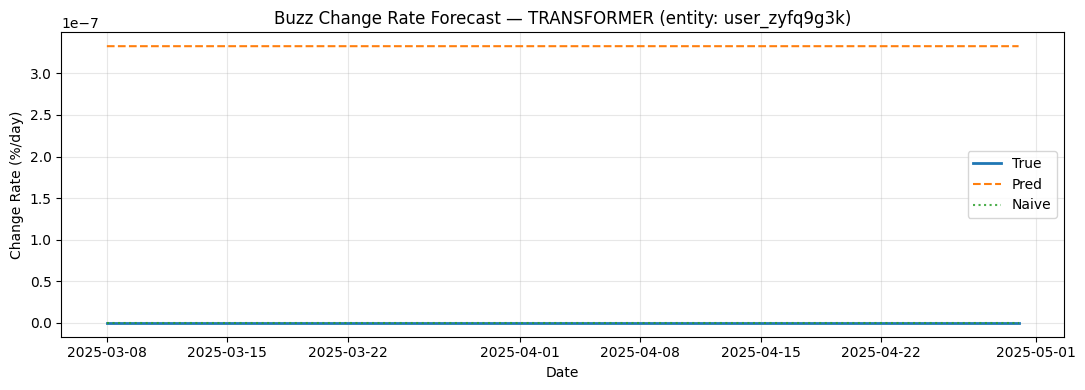

Plot: /content/workdir/buzz_forecast_fixed.png


In [ ]:
# ============================================================
# Buzz Change Rate Forecast (fixed baseline alignment)
# ============================================================

!pip -q install "tensorflow==2.18.0" "pandas==2.2.2" "numpy==1.26.4" > /dev/null

import warnings
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

warnings.filterwarnings("ignore")
tf.keras.utils.set_random_seed(42); np.random.seed(42)

# ------------ Paths & config ------------
CANDIDATES = [
    "/content/Social Media Engagement Dataset.csv",
    "/mnt/data/Social Media Engagement Dataset.csv"
]
DATA_SRC = next((p for p in CANDIDATES if Path(p).exists()), CANDIDATES[0])

WORKDIR = Path("/content/workdir"); WORKDIR.mkdir(parents=True, exist_ok=True)
OUT_CSV  = WORKDIR / "buzz_forecast_fixed.csv"
OUT_PNG  = WORKDIR / "buzz_forecast_fixed.png"
MODEL_FP = WORKDIR / "buzz_model_fixed.keras"

MODEL_TYPE = "transformer"    # "transformer" | "lstm"
FREQ = "D"; WINDOW = 30; HORIZON = 1
SMOOTH_ROLL = 7
EPOCHS = 60; BATCH = 64; LR = 2e-3
VAL_TAIL = 0.15; TEST_TAIL = 0.15

# ------------ Helpers ------------
def norm_cols(df): return df.rename(columns=lambda c: c.strip().lower().replace(" ","_"))

def detect_cols(df):
    cols = set(df.columns)
    likes    = next((c for c in ["likes_count","likes"] if c in cols), None)
    shares   = next((c for c in ["shares_count","shares","retweets"] if c in cols), None)
    comments = next((c for c in ["comments_count","comments","replies"] if c in cols), None)
    tcol     = next((c for c in df.columns if any(k in c for k in ["time","date","created","timestamp","posted"])), None)
    campaign = next((c for c in ["campaign","campaign_id","series","topic"] if c in cols), None)
    user     = next((c for c in ["user_id","userid","author_id","username","user","creator_id","account_id"] if c in cols), None)
    return likes, shares, comments, tcol, campaign, user

def to_num(df, col):
    if not col: return
    if df[col].dtype == "object":
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(",","",regex=False), errors="coerce")

def pick_entity(df, time_col, group_col=None):
    if group_col and group_col in df.columns:
        g = df.groupby([group_col, pd.Grouper(key=time_col, freq=FREQ)])["engagement"].sum().reset_index()
        pivot = g.pivot(index=time_col, columns=group_col, values="engagement")
        target = pivot.count().sort_values(ascending=False).index[0]
        return pivot[target], str(target)
    return df.groupby(pd.Grouper(key=time_col, freq=FREQ))["engagement"].sum(), "global"

def make_windows(series: pd.Series, window: int, horizon: int):
    vals = series.values.astype("float32")
    X, y, idx = [], [], []
    for i in range(0, len(vals) - window - horizon + 1):
        seg = vals[i:i+window]; tgt = vals[i+window + horizon - 1]
        if np.isnan(seg).any() or np.isnan(tgt): continue
        X.append(seg[:,None]); y.append(tgt); idx.append(series.index[i+window + horizon - 1])
    if not X: return np.empty((0,window,1),dtype="float32"), np.empty((0,),dtype="float32"), []
    return np.stack(X,axis=0), np.array(y,dtype="float32"), idx

def build_lstm(win):
    inp = layers.Input(shape=(win,1))
    x = layers.LSTM(64, return_sequences=True)(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(32)(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(1)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(LR), loss=keras.losses.Huber())
    return m

def positional_encoding(length, d_model):
    pos = np.arange(length)[:, None]; i = np.arange(d_model)[None, :]
    angle = pos / np.power(10000, (2*(i//2))/d_model)
    pe = np.zeros((length, d_model), dtype="float32")
    pe[:, 0::2] = np.sin(angle[:, 0::2]); pe[:, 1::2] = np.cos(angle[:, 1::2])
    return tf.constant(pe)

class AddPE(layers.Layer):
    def build(self, input_shape): self.pe = positional_encoding(input_shape[1], input_shape[2])
    def call(self, x): return x + self.pe

def build_transformer(win, d_model=64, heads=4, ff=128, blocks=2):
    inp = layers.Input(shape=(win,1))
    x = layers.Dense(d_model)(inp)
    x = AddPE()(x)
    for _ in range(blocks):
        a = layers.MultiHeadAttention(num_heads=heads, key_dim=d_model//heads)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + a)
        f = layers.Dense(ff, activation="relu")(x)
        f = layers.Dense(d_model)(f)
        x = layers.LayerNormalization(epsilon=1e-6)(x + f)
        x = layers.Dropout(0.1)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(LR), loss=keras.losses.Huber())
    return m

# ------------ Load & preprocess ------------
if not Path(DATA_SRC).exists():
    from google.colab import files
    uploaded = files.upload(); DATA_SRC = "/content/" + next(iter(uploaded.keys()))

df = pd.read_csv(DATA_SRC); df = norm_cols(df)
likes, shares, comments, time_col, campaign_col, user_col = detect_cols(df)
if not any([likes, shares, comments]): raise RuntimeError("Thiếu likes/shares/comments.")

for c in [likes, shares, comments]: to_num(df, c)
df["engagement"] = sum(df[c].fillna(0.0) for c in [likes, shares, comments] if c)

if not time_col: raise RuntimeError("Thiếu cột thời gian.")
df[time_col] = pd.to_datetime(df[time_col], errors="coerce", utc=True)
df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)

group_col = campaign_col if (campaign_col in df.columns) else (user_col if user_col in df.columns else None)
buzz, entity_name = pick_entity(df, time_col, group_col)
buzz = buzz.asfreq(FREQ).fillna(0.0)
if SMOOTH_ROLL>1: buzz = buzz.rolling(SMOOTH_ROLL, min_periods=1).mean()

# --- Target: log-return + clip ---
bcr = np.log1p(buzz).diff().fillna(0.0).clip(-0.1, 0.1)

# Auto hạ WINDOW nếu ngắn
if bcr.dropna().shape[0] < WINDOW + 20:
    WINDOW = max(7, min(14, bcr.dropna().shape[0] // 3))
    print(f"⚠️ Dữ liệu ngắn — hạ WINDOW xuống {WINDOW}")

# Tách train/val/test theo thời gian (trước scaling)
N_all = len(bcr)
def _split_idx(n, test_tail, val_tail):
    n_test = max(16, int(n * test_tail))
    n_val  = max(16, int((n - n_test) * val_tail))
    n_train= n - n_val - n_test
    return n_train, n_val, n_test
n_train, n_val, n_test = _split_idx(N_all, TEST_TAIL, VAL_TAIL)

bcr_train = bcr.iloc[:n_train]
bcr_val   = bcr.iloc[n_train:n_train+n_val]
bcr_test  = bcr.iloc[n_train+n_val:]

# Robust scaling FIT TRÊN TRAIN
med = bcr_train.median(); q1, q3 = bcr_train.quantile(0.25), bcr_train.quantile(0.75)
iqr = float(max(q3 - q1, 1e-6))

# Áp scaling cho toàn chuỗi (dùng tham số train)
bcr_s = pd.concat([
    (bcr_train - med) / iqr,
    (bcr_val   - med) / iqr,
    (bcr_test  - med) / iqr
])

# Windows sau scaling
X_all, y_all, idx_all = make_windows(bcr_s, WINDOW, HORIZON)
if X_all.shape[0] < 30: raise RuntimeError(f"Không đủ mẫu (N={X_all.shape[0]}).")

# Cắt theo biên train/val/test (sau window)
cut_train = max(0, n_train - (WINDOW + HORIZON - 1))
cut_val   = cut_train + max(0, n_val)
X_tr, y_tr = X_all[:cut_train], y_all[:cut_train]
X_va, y_va = X_all[cut_train:cut_val], y_all[cut_train:cut_val]
X_te, y_te = X_all[cut_val:], y_all[cut_val:]
idx_te     = idx_all[cut_val:]

print(f"Split -> train:{len(X_tr)} val:{len(X_va)} test:{len(X_te)} | entity={entity_name}")

# ------------ Train ------------
model = build_transformer(WINDOW) if MODEL_TYPE=="transformer" else build_lstm(WINDOW)
cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)]
model.fit(X_tr, y_tr, validation_data=(X_va, y_va) if len(X_va) else None,
          epochs=EPOCHS, batch_size=BATCH, verbose=0, callbacks=cb)
model.save(str(MODEL_FP))

# ------------ Inference & inverse scaling (→ %/day) ------------
pred_te_s = model.predict(X_te, verbose=0).reshape(-1)
true_te_s = y_te
pred_logret = pred_te_s * iqr + med
true_logret = true_te_s * iqr + med
pred_rate = np.expm1(pred_logret)
true_rate = np.expm1(true_logret)

# ====== Baseline naive ALIGNED với idx_te ======
# Dự báo = log-return của ngày liền trước mỗi mốc idx_te (từ chuỗi gốc bcr)
prev_idx = pd.to_datetime(idx_te) - pd.Timedelta(days=1)
naive_logret = bcr.reindex(prev_idx).fillna(0.0).values  # cùng chiều với idx_te
naive_rate   = np.expm1(naive_logret)

# ---- Metrics ----
rmse = float(np.sqrt(np.mean((pred_rate - true_rate)**2)))
mape = float(np.mean(np.abs((true_rate - pred_rate) / np.maximum(np.abs(true_rate), 1e-6))) * 100)
rmse_naive = float(np.sqrt(np.mean((naive_rate - true_rate)**2)))
print(f"✅ Test RMSE={rmse:.6f} | MAPE={mape:.3f}% | Baseline RMSE={rmse_naive:.6f}")

# ------------ Save & plot ------------
out_df = pd.DataFrame({
    "date": pd.to_datetime(idx_te),
    "true_rate": true_rate,
    "pred_rate": pred_rate,
    "naive_rate": naive_rate
}).sort_values("date")
out_df.to_csv(OUT_CSV, index=False, encoding="utf-8")
print("Saved:", OUT_CSV)

plt.figure(figsize=(11,4))
plt.plot(out_df["date"], out_df["true_rate"]*100, label="True", linewidth=2)
plt.plot(out_df["date"], out_df["pred_rate"]*100, label="Pred", linestyle="--")
plt.plot(out_df["date"], out_df["naive_rate"]*100, label="Naive", linestyle=":", alpha=.85)
plt.title(f"Buzz Change Rate Forecast — {MODEL_TYPE.upper()} (entity: {entity_name})")
plt.xlabel("Date"); plt.ylabel("Change Rate (%/day)")
plt.grid(True, alpha=.3); plt.legend(); plt.tight_layout()
plt.savefig(OUT_PNG, dpi=120); plt.show()
print("Plot:", OUT_PNG)
